# Model Comparison

# Import packages

In [1]:
%load_ext autoreload
%autoreload 2
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.path as mpath
import matplotlib.cm as cm
import matplotlib.patches as mpatches
from matplotlib.patches import Rectangle
from matplotlib.patches import Circle
import seaborn as sns
import numpy as np
import pandas as pd
import scipy
import datetime
import cartopy
from metpy.units import units
import cartopy.crs as ccrs
import pickle
import os
import glob
import subprocess
import dask
from joblib import Parallel, delayed
from geopy.distance import distance  
from scipy.stats import linregress
from scipy.optimize import curve_fit


import concurrent.futures

### Load MOAAP functions
import sys
sys.path.append('/work/aa0049/a271122/MOAAP/MOAAP/')
from src.utils import *
from src.Corrections import * 
from src.Enumerations import Month, Season, Experiments, Domains
from src.xarray_util import create_obj_from_dict,  ObjectContainer,  load_tracking_objects
from src.plot_funcs import plot_contourf_rotated_grid #, plot_unstructured_rotated_grid

from src.GridPoints import Domain


from ERA5_utils import *

/work/aa0049/a271122/MOAAP/MOAAP/src/xarray_util.py:28: AccessorRegistrationWarning: registration of accessor <class 'src.xarray_util.Accessor'> under name 'get' for type <class 'xarray.core.dataset.Dataset'> is overriding a preexisting attribute with the same name.
  class Accessor:


In [2]:
dask.config.set(**{'array.slicing.split_large_chunks': True})

In [3]:
ICON_CNRM_path = '/work/aa0049/a271041/CMOR/ARC-11/AWI/CNRM-ESM2-1/ssp370/r1i1p1f2/AWI-ICON2-6-6/v1/1hr/'

In [4]:
ICON_clim_path = '/work/aa0049/a271122/ICON_CNRM/ssp/'

# Load Objects

In [5]:
# Extract the rotated coordinate system from example file
ds=xr.open_dataset('/work/aa0049/a271041/spice-v2.1/chain/work/run_era5_polarres_wp3_hindcast2/post/yearly/T_2M/T_2M_2020010100-2020123123.ncz')

crs_rot = ccrs.RotatedPole(pole_longitude=ds.rotated_pole.attrs['grid_north_pole_longitude'],\
                           pole_latitude=ds.rotated_pole.attrs['grid_north_pole_latitude'])

# Define custom sectors for selection

In [6]:
from enum import Enum

class Domains(Enum):
    NORTH_ATLANTIC = Domain(north=70, south=50, east=0, west=-60)
    NORTH_PACIFIC = Domain(north=70, south=40, east=-140, west=160)
    CENTRAL_ARCTIC = Domain(north=90, south=70, east=180, west=-180)
    FRAM_STRAIT = Domain(north=81, south=77, east=10, west=-10)
    GREENLAND_SEA = Domain(north=80, south=75, east=10, west=-20)
    BERING_STRAIT = Domain(north=70, south=65, east=-150, west=160)
    BAFFIN_BAY = Domain(north=75, south=65, east=-55, west=-80)
    ARCTIC_ENTRANCE_NA = Domain(north=72, south=69, east=20, west=-25)
    NORTH_AMERICA = Domain(north=70, south=60, east=-80, west=-140)
    SIBERIA = Domain(north=70, south=60, east=135, west=75)

    # JLa custom domains
    NORTH_ATLANTIC_JLa = Domain(north=80, south=67, east=60, west=-30)
    BEAUFORT_SIBERIAN_JLa = Domain(north=80, south=70, east=-120, west=120)
    CENTRAL_ARCTIC_JLa = Domain(north=90, south=80, east=180, west=-180)



# Define new domain values
NORTH_ATLANTIC_JLa = Domain(north=80, south=67, east=60, west=-30)
BEAUFORT_SIBERIAN_JLa = Domain(north=80, south=70, east=120, west=-120)
CENTRAL_ARCTIC_JLa = Domain(north=90, south=80, east=180, west=-180)


gridspacing=0.75
lat=np.arange(-90, 90+gridspacing,gridspacing)
lon=np.arange(-180, 180+gridspacing,gridspacing)
ds_dummy = xr.Dataset({"dummy": (("lat", "lon"), np.ones([len(lat), len(lon)]))},coords={"lon": lon,"lat": lat})


dd=ds_dummy.copy()
mask_domain_CentralArctic=dd.dummy.where(dd.lat>80).notnull()
mask_domain_NorthAtlantic=dd.dummy.where((dd.lat<=80) & (dd.lat>67) & (dd.lon>-30) & (dd.lon<60)).notnull()
mask_domain_BeaufortSiberianSea1=dd.dummy.where((dd.lat<=80) & (dd.lat>70) & (dd.lon>120)).notnull()
mask_domain_BeaufortSiberianSea2=dd.dummy.where((dd.lat<=80) & (dd.lat>70) & (dd.lon<-120)).notnull()

mask_domain_BeaufortSiberianSea = mask_domain_BeaufortSiberianSea1 | mask_domain_BeaufortSiberianSea2

mask_domains = {
    "CentralArctic": {"mask": mask_domain_CentralArctic, "color": 'b',"north":90,"south":80,"east":180,"west":-180},
    "NorthAtlantic": {"mask": mask_domain_NorthAtlantic, "color": 'r',"north":80,"south":67,"east":60,"west":-30},
    "BeaufortSiberianSea": {"mask": mask_domain_BeaufortSiberianSea, "color": 'g',"north":80,"south":70,"east":120,"west":-120},
}

domains = ["NorthAtlantic","CentralArctic","BeaufortSiberianSea"]

### ERA5

In [7]:
# ERA5
#Load the objects in the Object container 1979-2022 
objs_ERA5 = load_tracking_objects(
         input_path = Experiments.ERA5.value.IVTobj_out_path,
         input_file_name_temp = 'MOAPP_ERA5_100and85ERA5perc_remapped_3x',
         type_ = 'IVT', 
         first_year = 1979,
         last_year  = 2022,
         load_clusters = True,
         load_coordinates=True,
         exp=Experiments.ERA5.value)

/work/aa0238/a271093/results/MOAAP/IVT_Tracking/ERA5_ICON_remapped_3x/Object_container_1979-2022_withClusters exists. Loading...


In [8]:
objs_sel_all_ERA5, ids_sel_all_ERA5 = sel_all_objects(objs_ERA5,season='DJF')

In [9]:
with open('/work/aa0049/a271122/MOAAP/IVT_Tracking/ERA5/Objects_transarctic_atlantic_ERA5.pkl', 'rb') as f:
   objs_sel_ERA5 = pickle.load(f)

In [10]:
#Select Atlantic WAIs 
objs_sel_tc_ERA5 = extract_and_transform_rot_coords(objs_sel_ERA5)
objs_final_ERA5 = create_final_objs(objs_sel_tc_ERA5)

13


#### NEW CLIMATOLOGY

In [23]:
with open('/work/aa0049/a271109/tools/MOAAP_functions_Jobo_v2025-02/ERA5/Object_container_2000-2022_DJF_IVT.pkl', 'rb') as f:
   objs_ERA5 = pickle.load(f)

In [37]:
objs_sel_all_ERA5, ids_sel_all_ERA5 = sel_all_objects(objs_ERA5,season='DJF')

In [25]:
objs_sel_ERA5 = sel_objs(objs_ERA5,season='DJF')

In [33]:
objs_sel_ERA5 = objs_sel_ERA5[0]

In [34]:
#Select Atlantic WAIs 
objs_sel_tc_ERA5 = extract_and_transform_rot_coords(objs_sel_ERA5)
objs_final_ERA5 = create_final_objs(objs_sel_tc_ERA5)

10


### ICON-ERA5

In [11]:
# ICON-ERA5
#Load the objects in the Object container 1979-2022 
objs_ICON_ERA5 = load_tracking_objects(
         input_path = Experiments.ICON_ERA5.value.IVTobj_out_path,
         input_file_name_temp = 'MOAPP_ICON_ERA5_100and85ERA5perc_remapped_3x',
         type_ = 'IVT', 
         first_year = 1998,
         last_year  = 2022,
         load_clusters = False,
         load_coordinates=True,
         exp=Experiments.ICON_ERA5.value)


/work/aa0238/a271093/results/MOAAP/IVT_Tracking/ICON_DRIVENBY_ERA5_remapped_3x/Object_container_1998-2022 exists. Loading...


In [12]:
objs_sel_all_ICON_ERA5, ids_sel_all_ICON_ERA5 = sel_all_objects(objs_ICON_ERA5,season='DJF')

In [13]:
#select objects that reach the central Arctic

In [14]:
with open('/work/aa0049/a271122/MOAAP/IVT_Tracking/ICON_ERA5/Objects_transarctic_atlantic_ERA5.pkl', 'rb') as f:
   objs_sel_ICONERA5 = pickle.load(f)

In [15]:
#Select Atlantic WAIs 
objs_sel_tc_ICONERA5 = extract_and_transform_rot_coords(objs_sel_ICONERA5)
objs_final_ICONERA5 = create_final_objs(objs_sel_tc_ICONERA5)

10


In [27]:
#select objects that reach the central Arctic
#objs_CA_ICONERA5, ids_CA_ICIBERA5 = sel_central_Arctic(objs_ICON_ERA5,season='DJF')
#len(objs_CA_ICONERA5)

#### NEW CLIMATOLOGY

In [36]:
with open('/work/aa0049/a271109/tools/MOAAP_functions_Jobo_v2025-02/ICON_ERA5/Object_container_2000-2022_DJF_IVT.pkl', 'rb') as f:
   objs_ICON_ERA5 = pickle.load(f)

In [38]:
objs_sel_all_ICON_ERA5, ids_sel_all_ICON_ERA5 = sel_all_objects(objs_ICON_ERA5,season='DJF')

In [39]:
objs_sel_ICONERA5 = sel_objs(objs_ICON_ERA5,season='DJF')

In [44]:
objs_sel_ICONERA5 = objs_sel_ICONERA5[0]

In [45]:
#Select Atlantic WAIs 
objs_sel_tc_ICONERA5 = extract_and_transform_rot_coords(objs_sel_ICONERA5)
objs_final_ICONERA5 = create_final_objs(objs_sel_tc_ICONERA5)

8


### ICON-CNRM

#### historical

In [28]:
#Historical all moisture transport events 
#with open('/work/aa0238/a271093/results/MOAAP/IVT_Tracking/CNRM_control_remapped_3x/Object_container_1984-2014_withClusters.pkl', 'rb') as f:
#   objs_historical = pickle.load(f) 

In [29]:
#objs_sel_historical_all, ids_sel_historical_all = sel_all_objects(objs_historical,season='DJF')

In [30]:
#with open('/work/aa0049/a271122/MOAAP/IVT_Tracking/CNRM_control_remapped_3x/Objects_all_CNRM.pkl', 'wb') as f:
#    pickle.dump(objs_sel_historical_all, f)

In [25]:
with open('/work/aa0049/a271122/MOAAP/IVT_Tracking/CNRM_control_remapped_3x/Objects_all_CNRM.pkl', 'rb') as f:
   objs_sel_historical_all = pickle.load(f)

In [26]:
#Historical transarctic events
#objs_sel_historical, ids_sel_historical = sel_objs(objs_historical,season='DJF')

In [27]:
with open('/work/aa0049/a271122/MOAAP/IVT_Tracking/CNRM_control_remapped_3x/Objects_transarctic_all_CNRM.pkl', 'rb') as f:
   objs_sel_historical = pickle.load(f)

In [34]:
#Select Atlantic WAIs 
objs_sel_tc_his = extract_and_transform_rot_coords(objs_sel_historical)
objs_final_his = create_final_objs(objs_sel_tc_his)

8


#### Objects 2015-2099

In [28]:
#with open('/work/aa0238/a271093/results/MOAAP/IVT_Tracking/CNRM_ssp_remapped_3x/Object_container_2015-2099_withClusters.pkl', 'rb') as f:
 #  objs = pickle.load(f) 

In [29]:
#SSP all transarctic events
#objs_sel, ids_sel = sel_objs(objs,season='DJF')

In [30]:
#with open('/work/aa0049/a271122/MOAAP/IVT_Tracking/CNRM_ssp_remapped_3x/Objects_transarctic_all_CNRM.pkl', 'wb') as f:
#    pickle.dump(objs_sel, f)

In [31]:
with open('/work/aa0049/a271122/MOAAP/IVT_Tracking/CNRM_ssp_remapped_3x/Objects_transarctic_atlantic_CNRM.pkl', 'rb') as f:
   objs_sel = pickle.load(f)

In [32]:
#Filter only Atlantic WAIs
objs_sel_tc = extract_and_transform_rot_coords(objs_sel)
objs_final = create_final_objs(objs_sel_tc)

48


In [33]:
#SSP all moisture transpoer objects
#objs_sel_all, ids_sel_all = sel_all_objects(objs,season='DJF')

In [34]:
#with open('/work/aa0049/a271122/MOAAP/IVT_Tracking/CNRM_ssp_remapped_3x/Objects_all_CNRM.pkl', 'wb') as f:
#    pickle.dump(objs_sel_all, f)

In [35]:
with open('/work/aa0049/a271122/MOAAP/IVT_Tracking/CNRM_ssp_remapped_3x/Objects_all_CNRM.pkl', 'rb') as f:
   objs_sel_all = pickle.load(f)

In [36]:
objs_ICON_CNRM_all = objs_sel_historical_all + objs_sel_all


### ICON-NorESM

#### historical

In [37]:
with open('/work/aa0049/a271122/MOAAP/IVT_Tracking/NorESM_ssp_remapped_3x/Object_container_1984-2014_all.pkl', 'rb') as f:
   objs_NorESM_his = pickle.load(f) 

In [38]:
#All objects
objs_sel_all_NorESM_his, ids_sel_all_NorESM_his = sel_all_objects(objs_NorESM_his,season='DJF')

In [39]:
#Transarctic WAIs
objs_sel_NorESM_his, ids_sel_NorESM_his = sel_objs(objs_NorESM_his,season='DJF')

In [40]:
#Select Atlantic WAIs 
objs_sel_tc_NorESM_his = extract_and_transform_rot_coords(objs_sel_NorESM_his)
objs_final_NorESM_his = create_final_objs(objs_sel_tc_NorESM_his)

10


#### Objects 2015-2099

In [41]:
#objs_sel_all_NorESM_ssp, ids_sel_all_NorESM_ssp = sel_all_objects(objs_ssp,season='DJF')

In [42]:
with open('/work/aa0049/a271122/MOAAP/IVT_Tracking/NorESM_ssp_remapped_3x/Object_container_ssp_all.pkl', 'rb') as f:
   objs_sel_all_NorESM_ssp = pickle.load(f) 

In [43]:
objs_sel_NorESM, ids_sel_NorESM = sel_objs(objs_sel_all_NorESM_ssp,season='DJF')

In [44]:
#Select Atlantic WAIs 
objs_sel_tc_NorESM = extract_and_transform_rot_coords(objs_sel_NorESM)
objs_final_NorESM = create_final_objs(objs_sel_tc_NorESM)

29


In [45]:
objs_ICON_NorESM_all = objs_sel_all_NorESM_his + objs_sel_all_NorESM_ssp

### Extract dates and frequency

#### ERA5

In [16]:
# Transarctic Objects
#1979-2022
dates_ERA5, length_ERA5 = extract_dates_freq(objs_final_ERA5) 

In [17]:
# ERA5 All events
dates_ERA5_all, length_ERA5_all = extract_dates_freq(objs_sel_all_ERA5) 

#### ICON-ERA5

In [18]:
# Transarctic Objects
#1979-2022
dates_ICONERA5,length_ICONERA5 = extract_dates_freq(objs_final_ICONERA5)

In [19]:
# ICON ERA5 All events
dates_ICON_ERA5_all, length_ICON_ERA5_all = extract_dates_freq(objs_sel_all_ICON_ERA5)


#### ICON-CNRM

In [53]:
# Transarctic Objects
#2015-2099
dates, length = extract_dates_freq(objs_final)

#1984-2014
dates_his, length_his = extract_dates_freq(objs_final_his)

In [54]:
# All events
dates_all,length_all = extract_dates_freq(objs_sel_all)

#Historical all
dates_his_all, length_his_all = extract_dates_freq(objs_sel_historical_all)

#### ICON-NorESM

In [55]:
# Transarctic Objects
#2015-2099
dates_NorESM, length_NorESM = extract_dates_freq(objs_final_NorESM)

#1984-2014
dates_NorESM_his, length_NorESM_his = extract_dates_freq(objs_final_NorESM_his)

In [56]:
# ICON_NorESM
#all
dates_NorESM_all, length_NorESM_all = extract_dates_freq(objs_sel_all_NorESM_ssp)

dates_NorESM_his_all, length_NorESM_his_all = extract_dates_freq(objs_sel_all_NorESM_his)

### Prepare df

#### All objects

In [20]:
## Load all DJF moisture transport events
#ERA5
df_ERA5 = sort_to_dt(dates_ERA5_all)

#ICON-ERA5
df_ICONERA5 = sort_to_dt(dates_ICON_ERA5_all)
df_ICONERA5 = df_ICONERA5.iloc[:-1]

In [59]:
# ICON-CNRM
df_ICONCNRM = sort_to_dt(dates_all)
df_ICONCNRM = df_ICONCNRM.iloc[:-1]

df_ICONCNRM_his = sort_to_dt(dates_his_all)

In [60]:
# ICON-NorESM
df_ICONNorESM = sort_to_dt(dates_NorESM_all)

df_ICONNorESM_his = sort_to_dt(dates_NorESM_his_all)

In [61]:
# Only for new climatology
#df_ERA5 = df_ERA5[1:-1]
#df_ICONERA5 = df_ICONERA5[1:-1]

#### Transarctic events

In [21]:
# ERA5
# transarctic WAIs historical and ssp
df_TA_ERA5 = sort_to_dt_TA(dates_ERA5)

In [22]:
# ICON-ERA5
# transarctic WAIs historical and ssp
df_TA_ICONERA5 = sort_to_dt_TA(dates_ICONERA5)

In [65]:
# ICON-CNRM
# transarctic WAIs historical and ssp
df_TA_ICONCNRM = pd.DataFrame({"Date": pd.to_datetime(dates)})
df_TA_his_ICONCNRM = pd.DataFrame({"Date": pd.to_datetime(dates_his)})
df_TA_ICONCNRM["Year"] = df_TA_ICONCNRM["Date"].dt.year
df_TA_his_ICONCNRM["Year"] = df_TA_his_ICONCNRM["Date"].dt.year

# Combine historical and ssp 
df_all_TA_ICONCNRM = pd.concat([df_TA_ICONCNRM, df_TA_his_ICONCNRM])
df_all_TA_ICONCNRM = df_all_TA_ICONCNRM["Year"].value_counts().sort_index().reset_index()
df_all_TA_ICONCNRM.columns = ["Year", "WAIs Count"]


In [66]:
# ICON-NorESM
# transarctic WAIs historical and ssp
df_TA_NorESM = pd.DataFrame({"Date": pd.to_datetime(dates_NorESM)})
df_TA_his_NorESM = pd.DataFrame({"Date": pd.to_datetime(dates_NorESM_his)})
df_TA_NorESM["Year"] = df_TA_NorESM["Date"].dt.year
df_TA_his_NorESM["Year"] = df_TA_his_NorESM["Date"].dt.year

# Combine historical and ssp 
df_all_TA_NorESM = pd.concat([df_TA_NorESM, df_TA_his_NorESM])
df_all_TA_NorESM = df_all_TA_NorESM["Year"].value_counts().sort_index().reset_index()
df_all_TA_NorESM.columns = ["Year", "WAIs Count"]



In [23]:
df_ERA5 = pd.read_csv('ERA5.csv')
df_ICONERA5 = pd.read_csv('ICON_ERA5.csv')
df_ICONCNRM = pd.read_csv('ICON_CNRM_ssp.csv')
df_ICONNorESM = pd.read_csv('ICON_NorESM_ssp.csv')
df_ICONCNRM_his = pd.read_csv('ICON_CNRM_historical.csv')
df_ICONNorESM_his = pd.read_csv('ICON_NorESM_historical.csv')
df_ICONCNRM = df_ICONCNRM[:-1]

df_TA_ERA5 = pd.read_csv('ERA5_TA.csv')
df_TA_ICONERA5 = pd.read_csv('ICON_ERA5_TA.csv')
df_all_TA_ICONCNRM = pd.read_csv('ICON_CNRM_transarctic_ssp.csv')
df_all_TA_ICONCNRM_his = pd.read_csv('ICON_CNRM_transarctic_historical.csv')


df_all_TA_NorESM_his = pd.read_csv('ICON_NorESM_transarctic_historical.csv')
df_all_TA_NorESM= pd.read_csv('ICON_NorESM_transarctic_ssp.csv')

### Filter by size

In [24]:
filtered_size_ERA5 = filter_by_size(objs_sel_all_ERA5)

In [25]:
filtered_size_ICONERA5 = filter_by_size(objs_sel_all_ICON_ERA5)

In [60]:
filtered_size_ICONCNRM = filter_by_size(objs_ICON_CNRM_all)

In [61]:
filtered_size_ICONNorESM = filter_by_size(objs_ICON_NorESM_all)

In [26]:
#1979-2022
# ERA5 All events
dates_ERA5_all, length_ERA5_all = extract_dates_freq(filtered_size_ERA5)

#ERA5
df_ERA5_filtered = sort_to_dt(dates_ERA5_all)

In [27]:
df_ERA5_filtered

,Year,Event Count
0,1979,189
1,1980,235
2,1981,227
3,1982,237
4,1983,218
5,1984,218
6,1985,199
7,1986,207
8,1987,233
9,1988,248


In [24]:
#df_ERA5_filtered.to_csv('ERA5_filtered.csv', index=False)

In [28]:
# ICON ERA5 All events
dates_ICON_ERA5_all, length_ICON_ERA5_all = extract_dates_freq(filtered_size_ICONERA5)
    
#ICON-ERA5
df_ICONERA5_filtered = sort_to_dt(dates_ICON_ERA5_all)
df_ICONERA5_filtered = df_ICONERA5_filtered.iloc[:-1]


In [29]:
df_ICONERA5_filtered

,Year,Event Count
0,1998,211
1,1999,218
2,2000,253
3,2001,262
4,2002,231
5,2003,235
6,2004,240
7,2005,256
8,2006,251
9,2007,245


In [82]:
df_all_TA_NorESM_his

,Date,Year
0,1985-12-23 11:00:00,1985
1,1987-02-14 09:00:00,1987
2,1996-02-01 00:00:00,1996
3,1996-02-10 18:00:00,1996
4,1999-02-26 20:00:00,1999
5,2001-01-08 08:00:00,2001
6,2001-01-08 21:00:00,2001
7,2007-02-16 10:00:00,2007
8,2013-02-15 20:00:00,2013
9,2013-02-19 09:00:00,2013


In [84]:
df_all_TA_ICONCNRM

,Year,WAIs Count
0,1984,1
1,1992,2
2,2002,1
3,2003,2
4,2005,1
5,2009,1
6,2015,1
7,2017,1
8,2019,1
9,2020,1


In [83]:
df_all_TA_NorESM

,Year,WAIs Count
0,1985,1
1,1987,1
2,1996,2
3,1999,1
4,2001,2
5,2007,1
6,2013,2
7,2022,1
8,2024,1
9,2025,2


In [72]:
## Load all DJF moisture transport events
# ICON-CNRM
# All events
dates_all, length_all = extract_dates_freq(filtered_size_ICONCNRM)

df_ICONCNRM_filtered = sort_to_dt(dates_all)
df_ICONCNRM_filtered = df_ICONCNRM_filtered.iloc[:-1]


# ICON_NorESM
#all
dates_NorESM_all, length_NorESM_all = extract_dates_freq(filtered_size_ICONNorESM)

df_ICONNorESM_filtered = sort_to_dt(dates_NorESM_all)

In [73]:
df_ICONCNRM_filtered.to_csv('ICON_CNRM_filtered.csv', index=False)

In [74]:
df_ICONCNRM_filtered = pd.read_csv('ICON_CNRM_filtered.csv')

In [75]:
df_ICONCNRM_filtered

,Year,Event Count
0,1984,218
1,1985,197
2,1986,186
3,1987,228
4,1988,238
...,...,...
109,2094,306
110,2095,299
111,2096,323
112,2097,265


In [77]:
df_ICONNorESM_filtered.to_csv('ICON_NorESM_filtered.csv', index=False)

In [78]:
df_ICONNorESM_filtered = pd.read_csv('ICON_NorESM_filtered.csv')

In [79]:
df_ICONNorESM_filtered

,Year,Event Count
0,1984,221
1,1985,199
2,1986,155
3,1987,156
4,1988,180
...,...,...
109,2094,272
110,2095,281
111,2096,273
112,2097,288


In [65]:
df_ICONNorESM_filtered.min()

Year           1984
Event Count     155
dtype: int64

In [66]:
df_ICONCNRM_filtered.max()

Year           2098
Event Count     328
dtype: int64

In [76]:
df_all_TA_NorESM[17:40]

,Year,WAIs Count
17,2054,1
18,2062,1
19,2070,2
20,2071,1
21,2074,1
22,2080,1
23,2083,1
24,2086,1
25,2088,1
26,2090,1


In [81]:
df_all_TA_ICONCNRM

,Year,WAIs Count
0,1984,1
1,1992,2
2,2002,1
3,2003,2
4,2005,1
5,2009,1
6,2015,1
7,2017,1
8,2019,1
9,2020,1


In [80]:
df_all_TA_ICONCNRM_his 

,Date,Year
0,1984-12-14 03:00:00,1984
1,1992-01-19 12:00:00,1992
2,1992-01-23 05:00:00,1992
3,2002-12-02 02:00:00,2002
4,2003-02-19 06:00:00,2003
5,2003-02-23 14:00:00,2003
6,2005-01-18 05:00:00,2005
7,2009-12-10 08:00:00,2009


## Plot

### New

In [75]:
plt.rcdefaults()

In [76]:
fig_width = 7.0 #3.4   # or 7.0
golden_ratio = (5**0.5 - 1) / 2 
fig_height = fig_width * golden_ratio

plt.rcParams.update({
    "figure.figsize": (fig_width, fig_height),
    "font.size": 17,               
    "axes.labelsize": 17,
    'axes.titlesize': 16,        # Title size    
    "xtick.labelsize": 15,
    "ytick.labelsize": 15,
    "legend.fontsize": 17,
    'lines.linewidth': 1.5,         # Line width
    'lines.markersize': 10,       # Marker size for lines
    "savefig.dpi": 300,
})

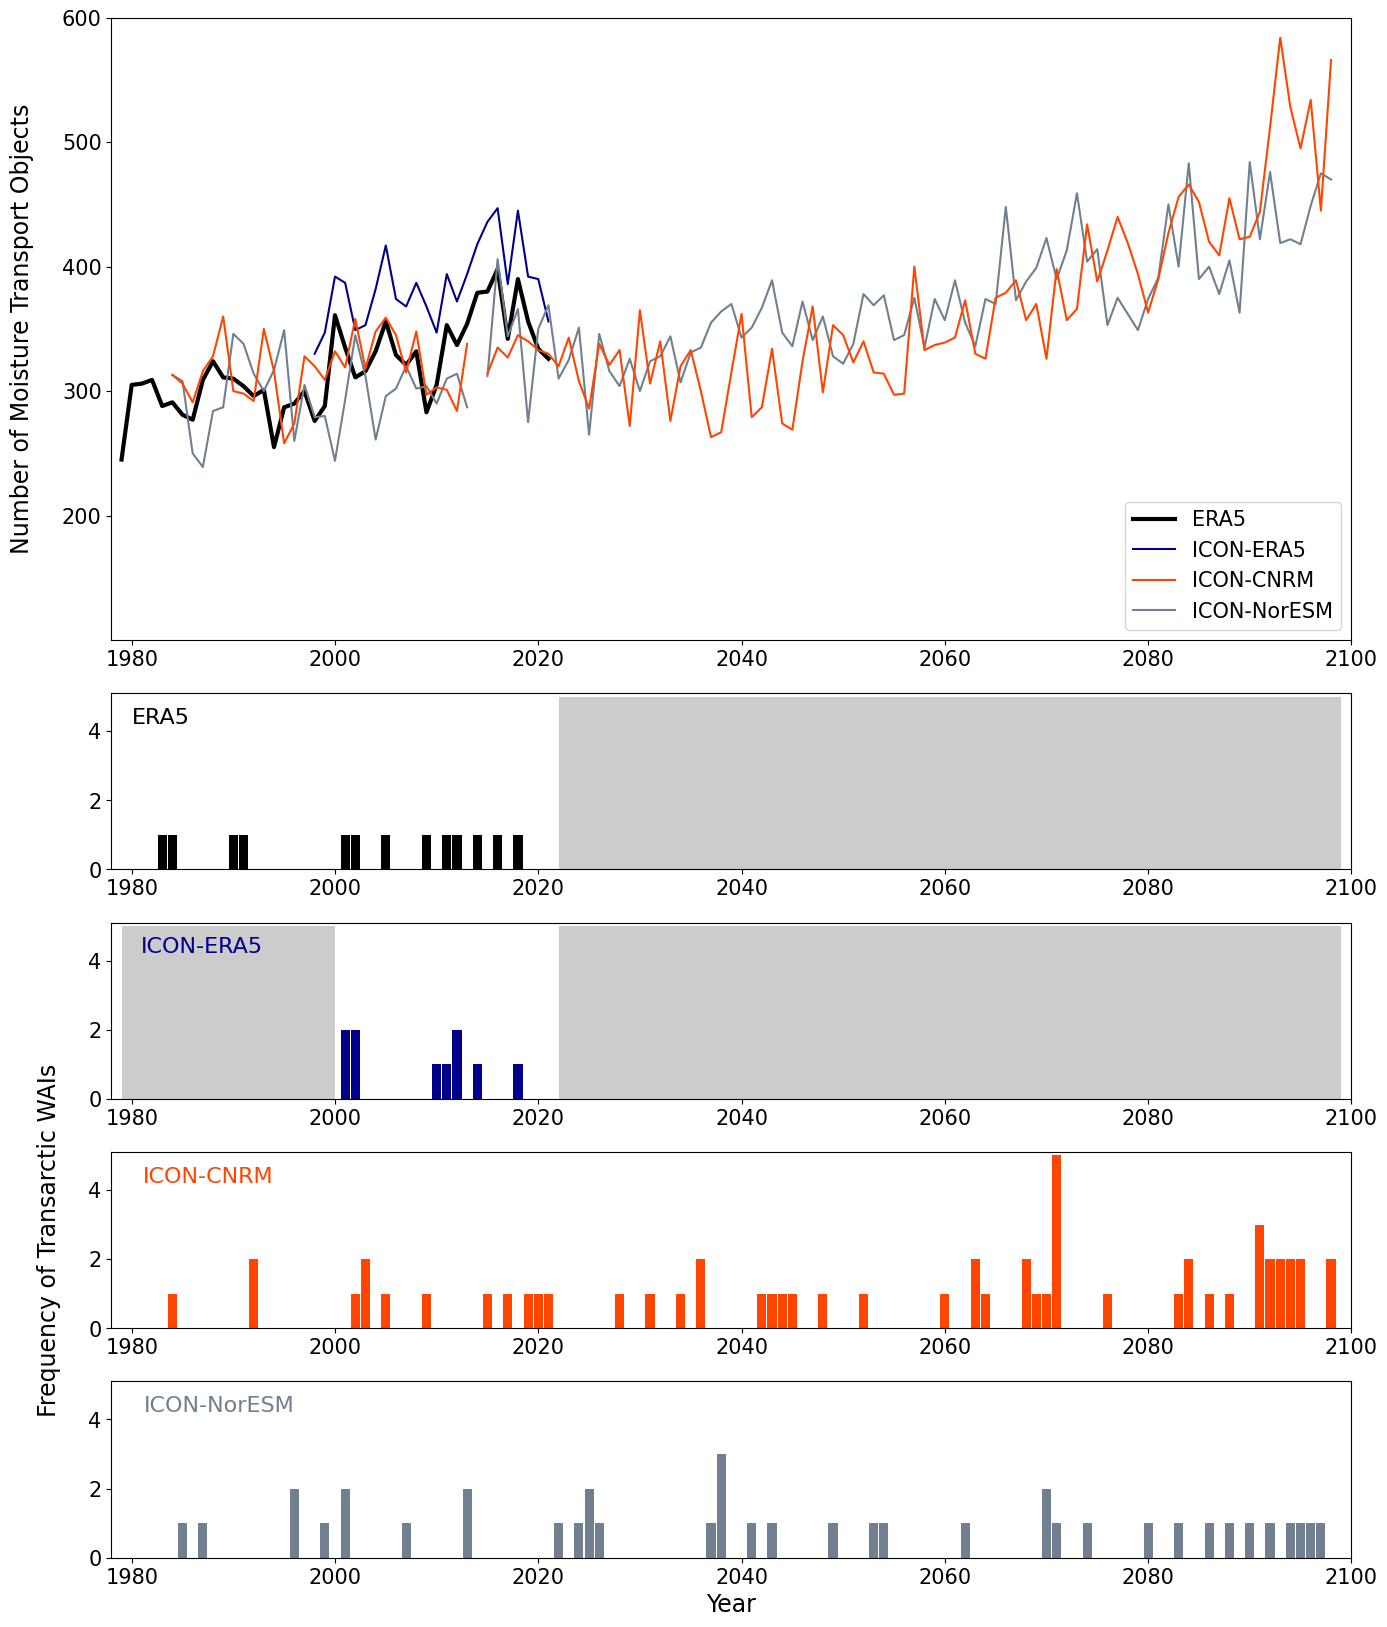

In [61]:
#Plot All Moisture Transport Objects + ERA5 + WAIs ICON-CNRM

#plt.rcdefaults()
# Plot
fig, axs = plt.subplots(5, 1, gridspec_kw={'height_ratios': [6, 1.7,1.7,1.7,1.7]},figsize=(16, 20))

##Main Figure
#Plot ERA5
sns.lineplot(data=df_ERA5, x="Year", y="Event Count", color="black", label="ERA5",linestyle='-', linewidth = 3,ax=axs[0],zorder=1,alpha=1)

#Plot ICON_ERA5
sns.lineplot(data=df_ICONERA5, x="Year", y="Event Count", color="darkblue", label="ICON-ERA5",linestyle='-', ax=axs[0],zorder=1)

# Plot regular events as line plots
sns.lineplot(data=df_ICONCNRM_his, x="Year", y="Event Count", color="orangered", linestyle='-', label="ICON-CNRM", ax=axs[0],zorder=5)
sns.lineplot(data=df_ICONCNRM, x="Year", y="Event Count", color="orangered",linestyle='-', ax=axs[0],zorder=5)

#Plot ICON-NorESM
sns.lineplot(data=df_ICONNorESM_his, x="Year", y="Event Count", color="slategrey", linestyle='-', label="ICON-NorESM", ax=axs[0],zorder=1,alpha=1)
sns.lineplot(data=df_ICONNorESM, x="Year", y="Event Count", color="slategrey",linestyle='-', ax=axs[0],zorder=1,alpha=1)


for aa in axs:
    aa.set_xlim([1978,2100])
    aa.set_ylim([0,5.1])
    aa.set_facecolor('white')  
    
# Main axis settings
axs[0].set_ylabel("Number of Moisture Transport Objects",labelpad=20)
axs[0].set_ylim([100, 600])
axs[0].set_yticks([200, 300, 400, 500, 600])
#axs[0].set_title("Wintertime Moisture Transport Objects & Transarctic WAIs 1979-2099",y=1.05)
axs[0].legend(loc="lower right",fontsize=15)

axs[3].set_ylabel("Frequency of Transarctic WAIs",labelpad=20,y=0.5)

axs[1].add_patch(mpatches.Rectangle((2022, 0), 77, 5, linewidth=1, edgecolor='none', facecolor="gray",alpha=0.4))
axs[2].add_patch(mpatches.Rectangle((1979, 0), 21, 5, linewidth=1,edgecolor='none', facecolor="gray",alpha=0.4))
axs[2].add_patch(mpatches.Rectangle((2022, 0), 77, 5, linewidth=1,edgecolor='none', facecolor="gray",alpha=0.4))

# Lower Figure
for _, row in df_TA_ERA5.iterrows():
    # The color of the bars is based on the frequency, but the height is constant (600)
    #grey background for no data
    axs[1].bar(row["Year"], height=row["WAIs Count"],color='black', width=0.9, alpha=1.0)
    axs[1].set_title("ERA5",y=0.78,x=0.040,color='black')
    #axs[1].add_patch(mpatches.Rectangle((2022, 0), 77, 5, linewidth=1, edgecolor='none', facecolor="gray",alpha=0.4))

for _, row in df_TA_ICONERA5.iterrows():
    
    # The color of the bars is based on the frequency, but the height is constant (600)
    axs[2].bar(row["Year"], height=row["WAIs Count"],color='darkblue', width=0.9)#, alpha=0.5)
    axs[2].set_title("ICON-ERA5",y=0.78,x=0.073,color='darkblue',alpha=1)


for _, row in df_all_TA_ICONCNRM.iterrows():
    # The color of the bars is based on the frequency, but the height is constant (600)
    axs[3].bar(row["Year"], height=row["WAIs Count"],color='orangered', width=0.9, alpha=1.0)
    axs[3].set_title("ICON-CNRM",y=0.78,x=0.078,color='orangered')
for _, row in df_all_TA_NorESM.iterrows():
    # The color of the bars is based on the frequency, but the height is constant (600)
    axs[4].bar(row["Year"], height=row["WAIs Count"],color='slategrey', width=0.9, alpha=1)
    axs[4].set_title("ICON-NorESM",y=0.78,x=0.087,color='slategrey',alpha=1)

axs[4].set_xlabel("Year")
axs[0].set_xlabel("")
plt.savefig("Figure_comparison_IVT_Objects.png",format='png',dpi=300,bbox_inches='tight')


plt.show()


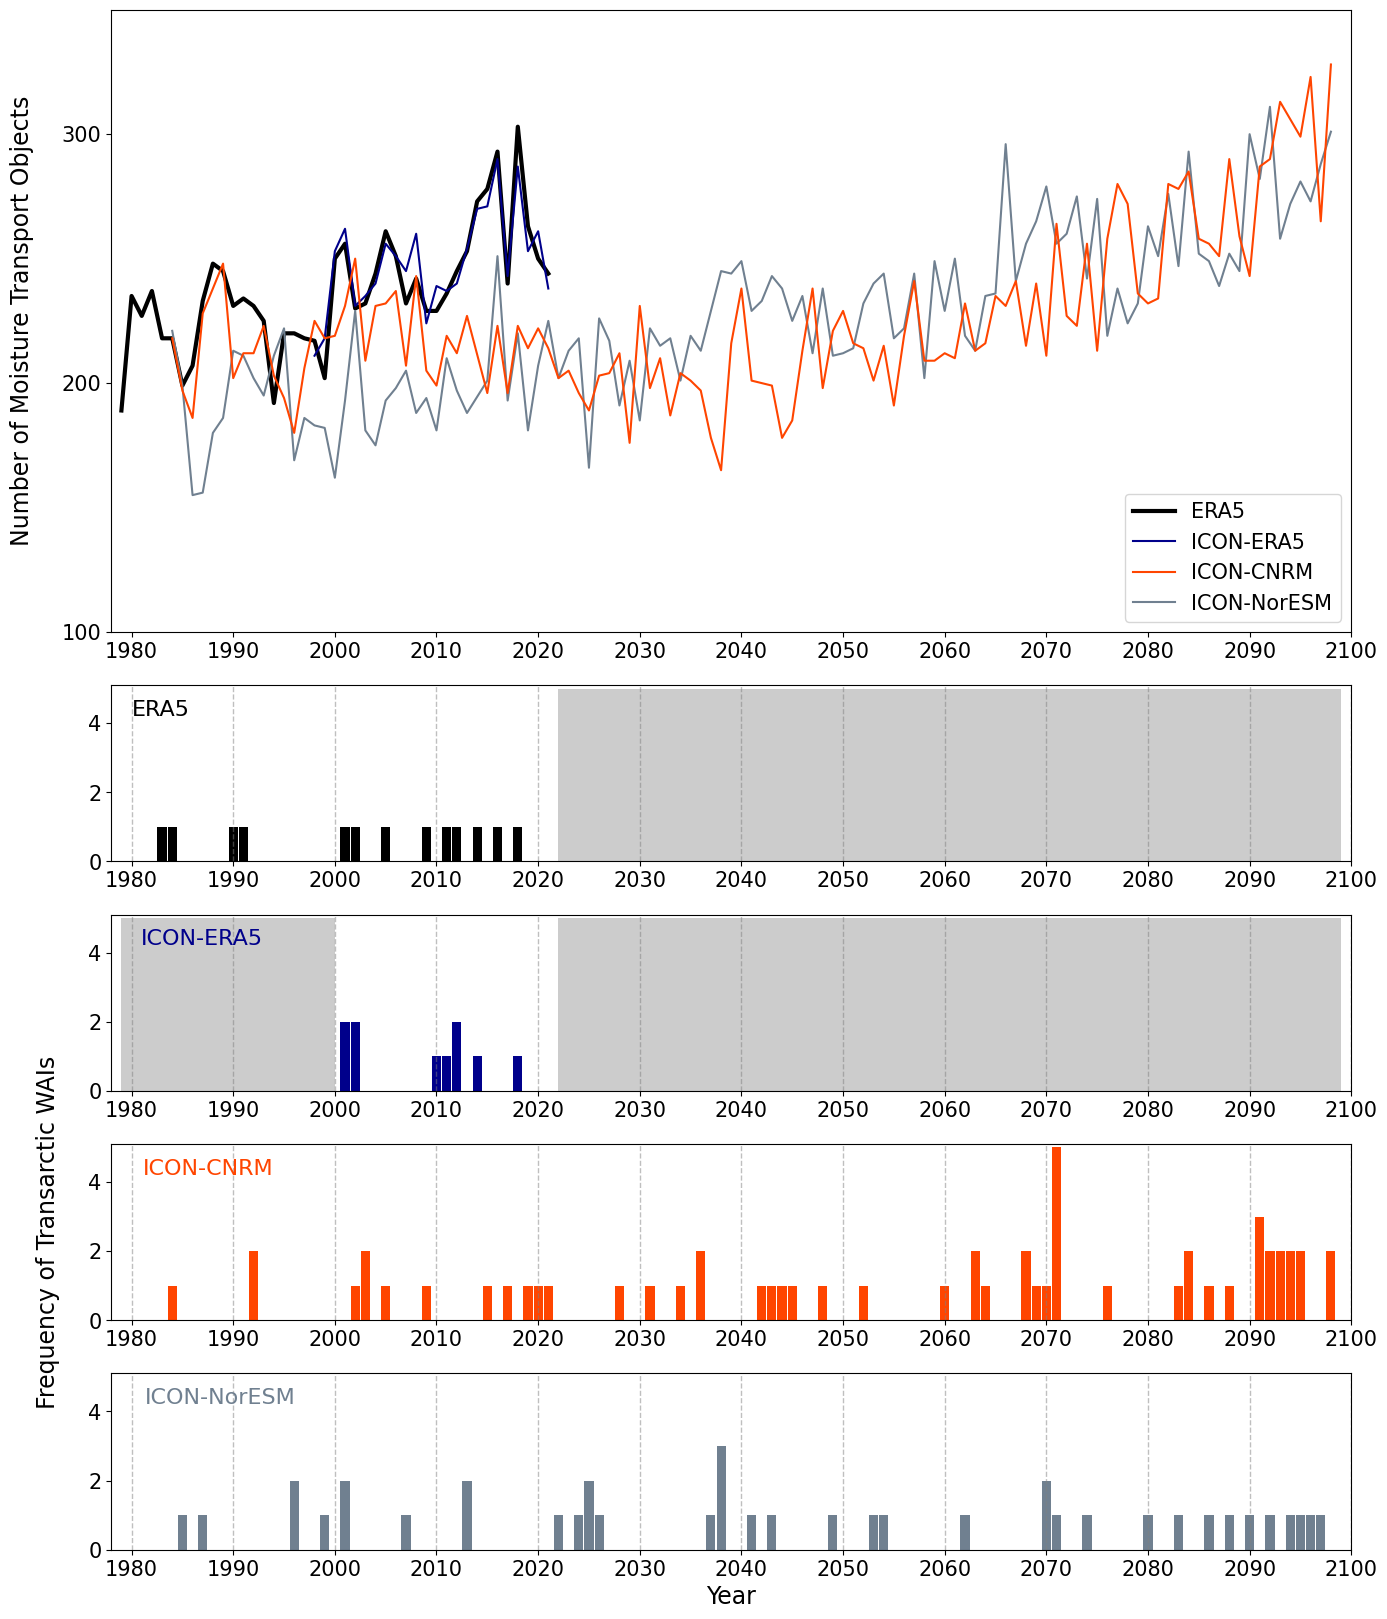

In [82]:
#Plot All Moisture Transport Objects + ERA5 + WAIs ICON-CNRM

#plt.rcdefaults()
# Plot
fig, axs = plt.subplots(5, 1, gridspec_kw={'height_ratios': [6, 1.7,1.7,1.7,1.7]},figsize=(16, 20))

##Main Figure
#Plot ERA5
sns.lineplot(data=df_ERA5_filtered, x="Year", y="Event Count", color="black", label="ERA5",linestyle='-', linewidth = 3,ax=axs[0],zorder=1,alpha=1)

#Plot ICON_ERA5
sns.lineplot(data=df_ICONERA5_filtered, x="Year", y="Event Count", color="darkblue", label="ICON-ERA5",linestyle='-', ax=axs[0],zorder=1)

# Plot regular events as line plots
#sns.lineplot(data=df_ICONCNRM_his, x="Year", y="Event Count", color="orangered", linestyle='-', label="ICON-CNRM", ax=axs[0],zorder=5)
sns.lineplot(data=df_ICONCNRM_filtered, x="Year", y="Event Count", color="orangered",label="ICON-CNRM",linestyle='-', ax=axs[0],zorder=5)

#Plot ICON-NorESM
#sns.lineplot(data=df_ICONNorESM_his, x="Year", y="Event Count", color="slategrey", linestyle='-', label="ICON-NorESM", ax=axs[0],zorder=1,alpha=1)
sns.lineplot(data=df_ICONNorESM_filtered, x="Year", y="Event Count", color="slategrey",linestyle='-',label="ICON-NorESM", ax=axs[0],zorder=1,alpha=1)


for aa in axs:
    aa.set_xlim([1978,2100])
    aa.set_xticks([1980,1990,2000,2010,2020,2030,2040,2050,2060,2070,2080,2090,2100])
    aa.set_ylim([0,5.1])
    aa.grid(axis='x',color='grey', linestyle='--', linewidth=1,alpha=0.5)
    aa.set_facecolor('white')  
    
# Main axis settings
axs[0].set_ylabel("Number of Moisture Transport Objects",labelpad=20)
axs[0].set_ylim([100, 350])
axs[0].grid(False)
axs[0].set_yticks([100,200, 300])
#axs[0].set_title("Wintertime Moisture Transport Objects & Transarctic WAIs 1979-2099",y=1.05)
axs[0].legend(loc="lower right",fontsize=15)

axs[3].set_ylabel("Frequency of Transarctic WAIs",labelpad=20,y=0.5)

axs[1].add_patch(mpatches.Rectangle((2022, 0), 77, 5, linewidth=1, edgecolor='none', facecolor="gray",alpha=0.4))
axs[2].add_patch(mpatches.Rectangle((1979, 0), 21, 5, linewidth=1,edgecolor='none', facecolor="gray",alpha=0.4))
axs[2].add_patch(mpatches.Rectangle((2022, 0), 77, 5, linewidth=1,edgecolor='none', facecolor="gray",alpha=0.4))

# Lower Figure
for _, row in df_TA_ERA5.iterrows():
    # The color of the bars is based on the frequency, but the height is constant (600)
    #grey background for no data
    axs[1].bar(row["Year"], height=row["WAIs Count"],color='black', width=0.9, alpha=1.0)
    axs[1].set_title("ERA5",y=0.78,x=0.040,color='black')
    #axs[1].add_patch(mpatches.Rectangle((2022, 0), 77, 5, linewidth=1, edgecolor='none', facecolor="gray",alpha=0.4))

for _, row in df_TA_ICONERA5.iterrows():
    
    # The color of the bars is based on the frequency, but the height is constant (600)
    axs[2].bar(row["Year"], height=row["WAIs Count"],color='darkblue', width=0.9)#, alpha=0.5)
    axs[2].set_title("ICON-ERA5",y=0.78,x=0.073,color='darkblue',alpha=1)


for _, row in df_all_TA_ICONCNRM.iterrows():
    # The color of the bars is based on the frequency, but the height is constant (600)
    axs[3].bar(row["Year"], height=row["WAIs Count"],color='orangered', width=0.9, alpha=1.0)
    axs[3].set_title("ICON-CNRM",y=0.78,x=0.078,color='orangered')
for _, row in df_all_TA_NorESM.iterrows():
    # The color of the bars is based on the frequency, but the height is constant (600)
    axs[4].bar(row["Year"], height=row["WAIs Count"],color='slategrey', width=0.9, alpha=1)
    axs[4].set_title("ICON-NorESM",y=0.78,x=0.088,color='slategrey',alpha=1)

axs[4].set_xlabel("Year")
axs[0].set_xlabel("")
plt.savefig("Figure_comparison_IVT_Objects_filtered.png",format='png',dpi=300,bbox_inches='tight')


plt.show()


### New Statistics

In [77]:
#ERA5
slope_ERA5_1, intercept_ERA5_1, r_value_ERA5_1, p_value_ERA5_1, std_err_ERA5_1 = linregress(df_ERA5_filtered[0:19]['Year'], df_ERA5_filtered[0:19]['Event Count'])
print(f"Linear R²: {r_value_ERA5_1**2}")

slope_ERA5_2, intercept_ERA5_2, r_value_ERA5_2, p_value_ERA5_2, std_err_ERA5_2 = linregress(df_ERA5_filtered[19:43]['Year'], df_ERA5_filtered[19:43]['Event Count'])
print(f"Linear R²: {r_value_ERA5_2**2}")

#ICON-ERA5
slope_ICONERA5, intercept_ICONERA5, r_value_ICONERA5, p_value_ICONERA5, std_err_ICONERA5 = linregress(df_ICONERA5_filtered['Year'], df_ICONERA5_filtered['Event Count'])
print(f"Linear R²: {r_value_ICONERA5**2}")

#ICON-CNRM
slope_ICONCNRM_1, intercept_ICONCNRM_1, r_value_ICONCNRM_1, p_value_ICONCNRM_1, std_err_ICONCNRM_1 = linregress(df_ICONCNRM_filtered[0:57]['Year'], df_ICONCNRM_filtered[0:57]['Event Count'])
print(f"Linear R²: {r_value_ICONCNRM_1**2}")
slope_ICONCNRM_2, intercept_ICONCNRM_2, r_value_ICONCNRM_2, p_value_ICONCNRM_2, std_err_ICONCNRM_2 = linregress(df_ICONCNRM_filtered[57:115]['Year'], df_ICONCNRM_filtered[57:115]['Event Count'])
print(f"Linear R²: {r_value_ICONCNRM_2**2}")

#ICON-NorESM
slope_ICONNorESM_1, intercept_ICONNorESM_1, r_value_ICONNorESM_1, p_value_ICONNorESM_1, std_err_ICONNorESM_1 = linregress(df_ICONNorESM_filtered[0:57]['Year'], df_ICONNorESM_filtered[0:57]['Event Count'])
print(f"Linear R²: {r_value_ICONNorESM_1**2}")
slope_ICONNorESM_2, intercept_ICONNorESM_2, r_value_ICONNorESM_2, p_value_ICONNorESM_2, std_err_ICONNorESM_2 = linregress(df_ICONNorESM_filtered[57:115]['Year'], df_ICONNorESM_filtered[57:115]['Event Count'])
print(f"Linear R²: {r_value_ICONNorESM_2**2}")

Linear R²: 0.00197889563457647
Linear R²: 0.3137898244386192
Linear R²: 0.26378256278758755
Linear R²: 0.09882754048497981
Linear R²: 0.7149126210657637
Linear R²: 0.2746014878482809
Linear R²: 0.44162800440486943


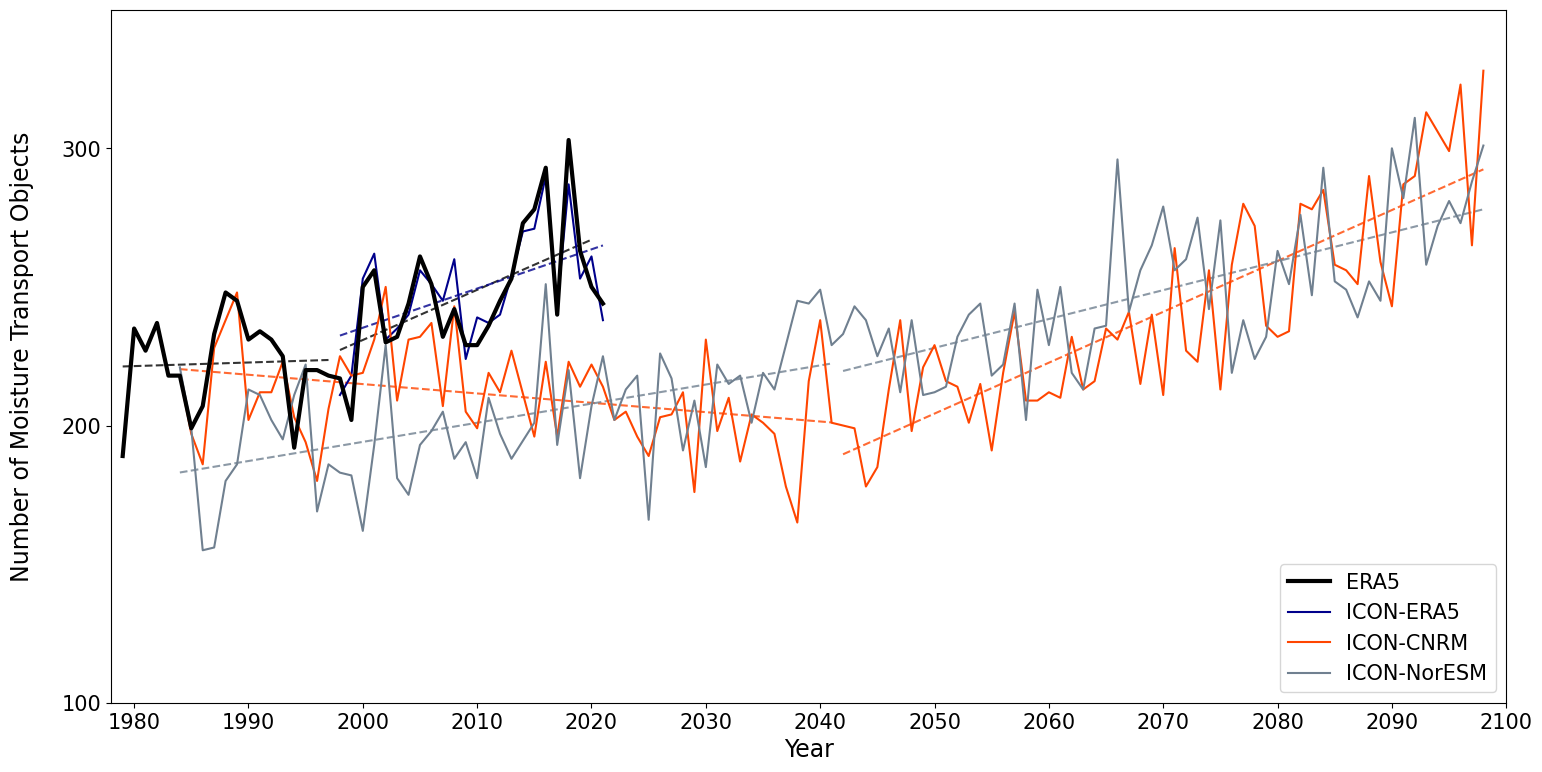

In [78]:
fig, ax = plt.subplots(1, 1,figsize=(18, 9))

##Main Figure
#Plot ERA5
sns.lineplot(data=df_ERA5_filtered, x="Year", y="Event Count", color="black", label="ERA5",linestyle='-', linewidth = 3,ax=ax,zorder=6,alpha=1)

#Plot ICON_ERA5
sns.lineplot(data=df_ICONERA5_filtered, x="Year", y="Event Count", color="darkblue", label="ICON-ERA5",linestyle='-', ax=ax,zorder=5)

# Plot regular events as line plots
#sns.lineplot(data=df_ICONCNRM_his, x="Year", y="Event Count", color="orangered", linestyle='-', label="ICON-CNRM", ax=axs[0],zorder=5)
sns.lineplot(data=df_ICONCNRM_filtered, x="Year", y="Event Count", color="orangered",label="ICON-CNRM",linestyle='-', ax=ax,zorder=5)

#Plot ICON-NorESM
#sns.lineplot(data=df_ICONNorESM_his, x="Year", y="Event Count", color="slategrey", linestyle='-', label="ICON-NorESM", ax=axs[0],zorder=1,alpha=1)
sns.lineplot(data=df_ICONNorESM_filtered, x="Year", y="Event Count", color="slategrey",linestyle='-',label="ICON-NorESM", ax=ax,zorder=5,alpha=1)


#ERA5 5 Linear Fit
plt.plot(df_ERA5_filtered[0:19]['Year'], intercept_ERA5_1 + slope_ERA5_1*df_ERA5_filtered[0:19]['Year'],'k',ls='--',alpha=0.8)
plt.plot(df_ERA5_filtered[19:-1]['Year'], intercept_ERA5_2 + slope_ERA5_2*df_ERA5_filtered[19:-1]['Year'],'k',ls='--',alpha=0.8)

plt.plot(df_ICONERA5_filtered['Year'], intercept_ICONERA5 + slope_ICONERA5*df_ICONERA5_filtered['Year'],'darkblue',ls='--',alpha=0.8)

plt.plot(df_ICONCNRM_filtered[0:57]['Year'], intercept_ICONCNRM_1 + slope_ICONCNRM_1*df_ICONCNRM_filtered[0:57]['Year'],'orangered',ls='--',alpha=0.8)
plt.plot(df_ICONCNRM_filtered[57:115]['Year'], intercept_ICONCNRM_2 + slope_ICONCNRM_2*df_ICONCNRM_filtered[57:115]['Year'],'orangered',ls='--',alpha=0.8)

plt.plot(df_ICONNorESM_filtered[0:57]['Year'], intercept_ICONNorESM_1 + slope_ICONNorESM_1*df_ICONNorESM_filtered[0:57]['Year'],'slategrey',ls='--',alpha=0.8)
plt.plot(df_ICONNorESM_filtered[57:115]['Year'], intercept_ICONNorESM_2 + slope_ICONNorESM_2*df_ICONNorESM_filtered[57:115]['Year'],'slategrey',ls='--',alpha=0.8)



#ERA5 
#plt.text(2000,204,f"{intercept_ERA5_1:.2f}= {slope_ERA5_1:.2f}x  \n R^2 = {r_value_ERA5_1**2:.4f} \n SE = {std_err_ERA5_1:.2f}",color='r')
#plt.text(2016,205,f"{intercept_ERA5_2:.2f}= {slope_ERA5_2:.2f}x  \n R^2 = {r_value_ERA5_2**2:.4f} \n SE = {std_err_ERA5_2:.2f}",color='r')

ax.set_xlim([1978,2100])
ax.set_xticks([1980,1990,2000,2010,2020,2030,2040,2050,2060,2070,2080,2090,2100])
ax.grid(axis='x',color='grey', linestyle='--', linewidth=1,alpha=0.5)
ax.set_facecolor('white')  

# Main axis settings
ax.set_ylabel("Number of Moisture Transport Objects",labelpad=20)
ax.set_ylim([100, 350])
ax.grid(False)
ax.set_yticks([100,200, 300])
#axs[0].set_title("Wintertime Moisture Transport Objects & Transarctic WAIs 1979-2099",y=1.05)
ax.legend(loc="lower right",fontsize=15)



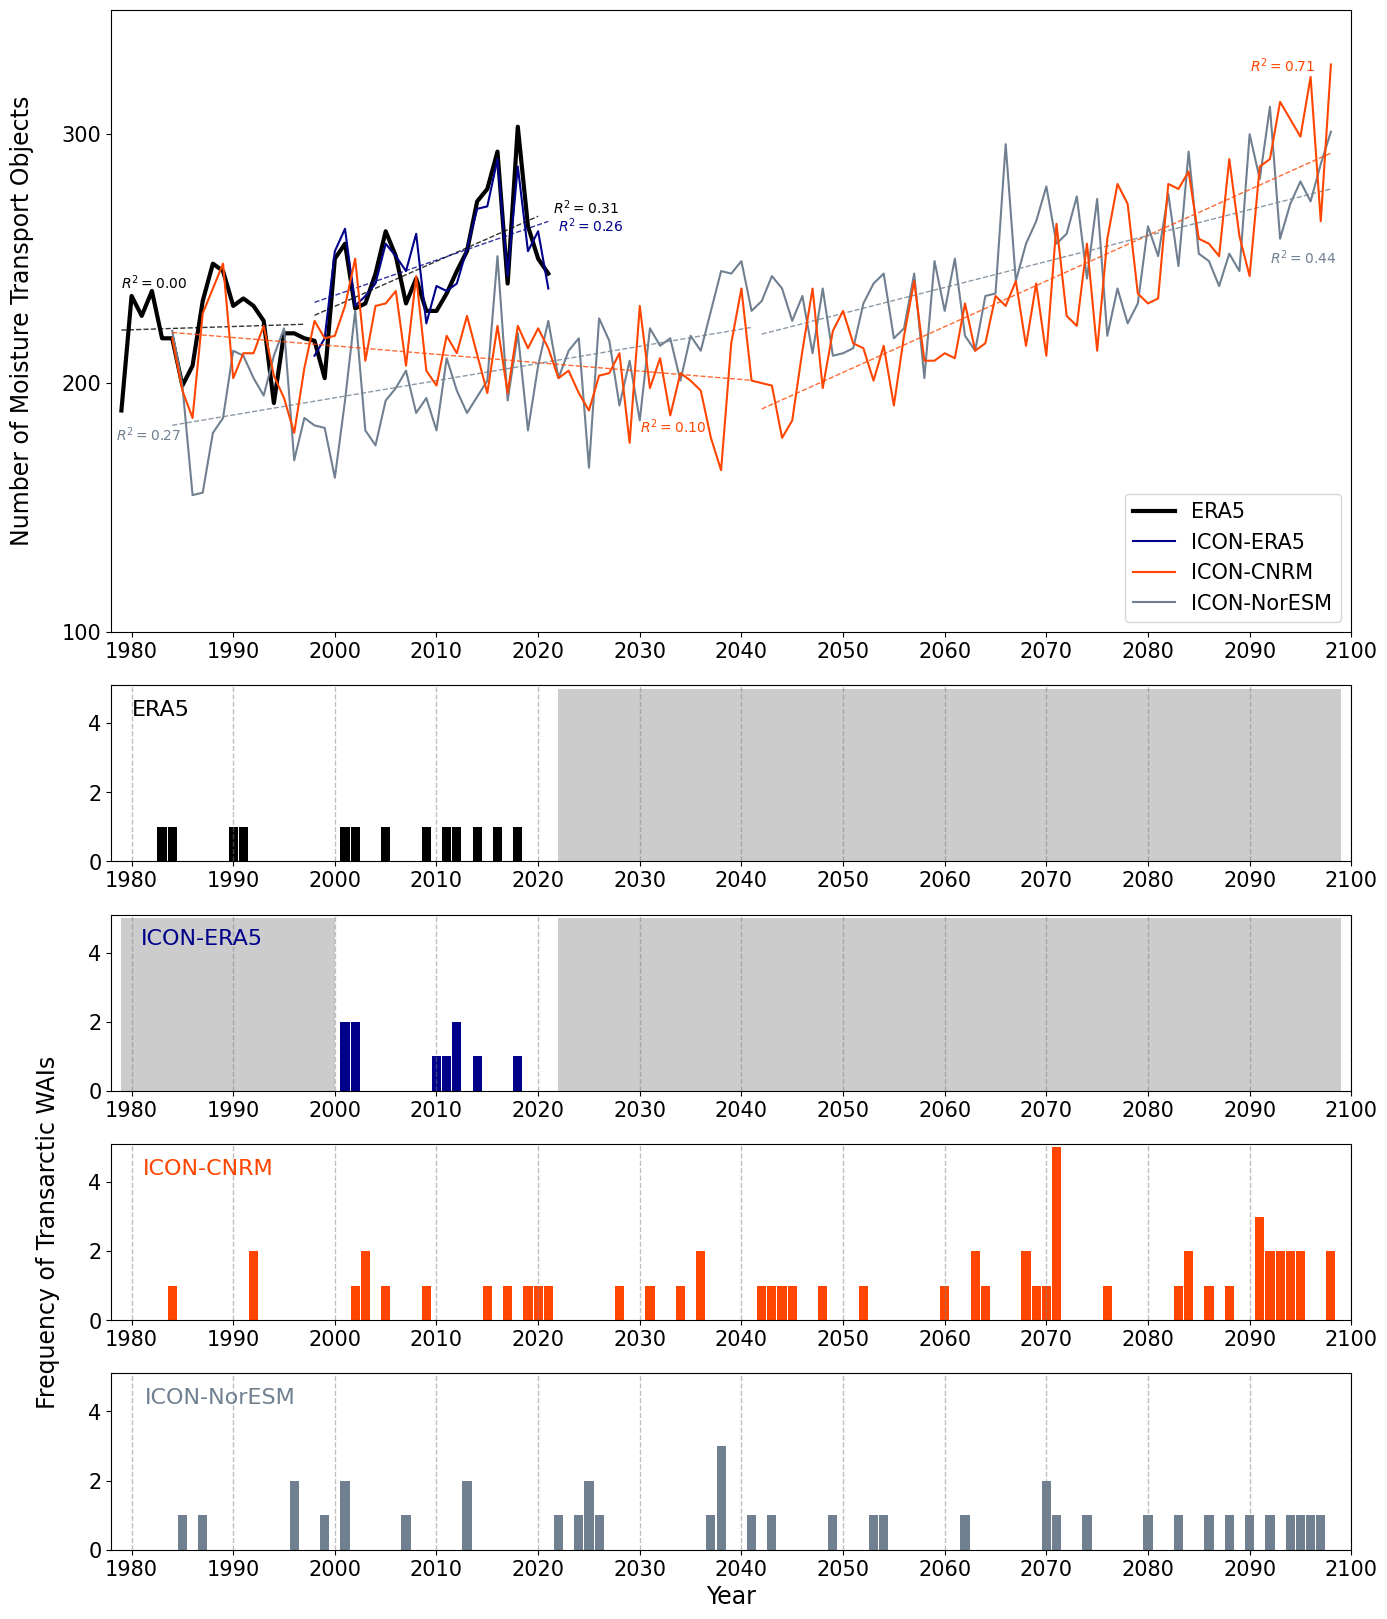

In [83]:
#Plot All Moisture Transport Objects + ERA5 + WAIs ICON-CNRM

#plt.rcdefaults()
# Plot
fig, axs = plt.subplots(5, 1, gridspec_kw={'height_ratios': [6, 1.7,1.7,1.7,1.7]},figsize=(16, 20))

##Main Figure
#Plot ERA5
sns.lineplot(data=df_ERA5_filtered, x="Year", y="Event Count", color="black", label="ERA5",linestyle='-', linewidth = 3,ax=axs[0],zorder=1,alpha=1)

#Plot ICON_ERA5
sns.lineplot(data=df_ICONERA5_filtered, x="Year", y="Event Count", color="darkblue", label="ICON-ERA5",linestyle='-', ax=axs[0],zorder=1)

# Plot regular events as line plots
#sns.lineplot(data=df_ICONCNRM_his, x="Year", y="Event Count", color="orangered", linestyle='-', label="ICON-CNRM", ax=axs[0],zorder=5)
sns.lineplot(data=df_ICONCNRM_filtered, x="Year", y="Event Count", color="orangered",label="ICON-CNRM",linestyle='-', ax=axs[0],zorder=5)

#Plot ICON-NorESM
#sns.lineplot(data=df_ICONNorESM_his, x="Year", y="Event Count", color="slategrey", linestyle='-', label="ICON-NorESM", ax=axs[0],zorder=1,alpha=1)
sns.lineplot(data=df_ICONNorESM_filtered, x="Year", y="Event Count", color="slategrey",linestyle='-',label="ICON-NorESM", ax=axs[0],zorder=1,alpha=1)



#ERA5 5 Linear Fit
axs[0].plot(df_ERA5_filtered[0:19]['Year'], intercept_ERA5_1 + slope_ERA5_1*df_ERA5_filtered[0:19]['Year'],'k',ls='--',alpha=0.8,linewidth = 1)
axs[0].plot(df_ERA5_filtered[19:-1]['Year'], intercept_ERA5_2 + slope_ERA5_2*df_ERA5_filtered[19:-1]['Year'],'k',ls='--',alpha=0.8,linewidth = 1)

axs[0].plot(df_ICONERA5_filtered['Year'], intercept_ICONERA5 + slope_ICONERA5*df_ICONERA5_filtered['Year'],'darkblue',ls='--',alpha=0.8,linewidth = 1)

axs[0].plot(df_ICONCNRM_filtered[0:57]['Year'], intercept_ICONCNRM_1 + slope_ICONCNRM_1*df_ICONCNRM_filtered[0:57]['Year'],'orangered',ls='--',alpha=0.8,linewidth = 1)
axs[0].plot(df_ICONCNRM_filtered[57:115]['Year'], intercept_ICONCNRM_2 + slope_ICONCNRM_2*df_ICONCNRM_filtered[57:115]['Year'],'orangered',ls='--',alpha=0.8,linewidth = 1)

axs[0].plot(df_ICONNorESM_filtered[0:57]['Year'], intercept_ICONNorESM_1 + slope_ICONNorESM_1*df_ICONNorESM_filtered[0:57]['Year'],'slategrey',ls='--',alpha=0.8,linewidth = 1)
axs[0].plot(df_ICONNorESM_filtered[57:115]['Year'], intercept_ICONNorESM_2 + slope_ICONNorESM_2*df_ICONNorESM_filtered[57:115]['Year'],'slategrey',ls='--',alpha=0.8,linewidth = 1)



#ERA5 
axs[0].text(1979,238,fr"$R^2={r_value_ERA5_1**2:.2f}$",color='k',fontsize=10)
axs[0].text(2021.5,268,fr"$R^2={r_value_ERA5_2**2:.2f}$",color='k',fontsize=10)

axs[0].text(2022,261,fr"$R^2={r_value_ICONERA5**2:.2f}$",color='darkblue',fontsize=10)

axs[0].text(2030,180,fr"$R^2={r_value_ICONCNRM_1**2:.2f}$",color='orangered',fontsize=10)
axs[0].text(2090,325,fr"$R^2={r_value_ICONCNRM_2**2:.2f}$",color='orangered',fontsize=10)

axs[0].text(1978.5,177,fr"$R^2={r_value_ICONNorESM_1**2:.2f}$",color='slategrey',fontsize=10)
axs[0].text(2092,248,fr"$R^2={r_value_ICONNorESM_2**2:.2f}$",color='slategrey',fontsize=10)


for aa in axs:
    aa.set_xlim([1978,2100])
    aa.set_xticks([1980,1990,2000,2010,2020,2030,2040,2050,2060,2070,2080,2090,2100])
    aa.set_ylim([0,5.1])
    aa.grid(axis='x',color='grey', linestyle='--', linewidth=1,alpha=0.5)
    aa.set_facecolor('white')  
    
# Main axis settings
axs[0].set_ylabel("Number of Moisture Transport Objects",labelpad=20)
axs[0].set_ylim([100, 350])
axs[0].grid(False)
axs[0].set_yticks([100,200, 300])
#axs[0].set_title("Wintertime Moisture Transport Objects & Transarctic WAIs 1979-2099",y=1.05)
axs[0].legend(loc="lower right",fontsize=15)

axs[3].set_ylabel("Frequency of Transarctic WAIs",labelpad=20,y=0.5)

axs[1].add_patch(mpatches.Rectangle((2022, 0), 77, 5, linewidth=1, edgecolor='none', facecolor="gray",alpha=0.4))
axs[2].add_patch(mpatches.Rectangle((1979, 0), 21, 5, linewidth=1,edgecolor='none', facecolor="gray",alpha=0.4))
axs[2].add_patch(mpatches.Rectangle((2022, 0), 77, 5, linewidth=1,edgecolor='none', facecolor="gray",alpha=0.4))

# Lower Figure
for _, row in df_TA_ERA5.iterrows():
    # The color of the bars is based on the frequency, but the height is constant (600)
    #grey background for no data
    axs[1].bar(row["Year"], height=row["WAIs Count"],color='black', width=0.9, alpha=1.0)
    axs[1].set_title("ERA5",y=0.78,x=0.040,color='black')
    #axs[1].add_patch(mpatches.Rectangle((2022, 0), 77, 5, linewidth=1, edgecolor='none', facecolor="gray",alpha=0.4))

for _, row in df_TA_ICONERA5.iterrows():
    
    # The color of the bars is based on the frequency, but the height is constant (600)
    axs[2].bar(row["Year"], height=row["WAIs Count"],color='darkblue', width=0.9)#, alpha=0.5)
    axs[2].set_title("ICON-ERA5",y=0.78,x=0.073,color='darkblue',alpha=1)


for _, row in df_all_TA_ICONCNRM.iterrows():
    # The color of the bars is based on the frequency, but the height is constant (600)
    axs[3].bar(row["Year"], height=row["WAIs Count"],color='orangered', width=0.9, alpha=1.0)
    axs[3].set_title("ICON-CNRM",y=0.78,x=0.078,color='orangered')
for _, row in df_all_TA_NorESM.iterrows():
    # The color of the bars is based on the frequency, but the height is constant (600)
    axs[4].bar(row["Year"], height=row["WAIs Count"],color='slategrey', width=0.9, alpha=1)
    axs[4].set_title("ICON-NorESM",y=0.78,x=0.088,color='slategrey',alpha=1)

axs[4].set_xlabel("Year")
axs[0].set_xlabel("")
plt.savefig("Figure_comparison_IVT_Objects_filtered.png",format='png',dpi=300,bbox_inches='tight')


plt.show()


In [80]:
def growth_rate(model, years, slope,period):
    growth_rate = (slope) *10
    print(f"{model}: Growth rate per decade: {growth_rate:.2f}, Period: {period}")

In [81]:
growth_rate('ERA5',1997-1979, slope_ERA5_1,'1979-1997')
growth_rate('ERA5',2022-1998, slope_ERA5_2,'1998-2022')

growth_rate('ICON-ERA5',2022-1998, slope_ICONERA5,'1998-2022')

growth_rate('ICON-CNRM',2041-1984, slope_ICONCNRM_1,'1984-2041')
growth_rate('ICON-CNRM',2099-2042, slope_ICONCNRM_2,'2042-2099')

growth_rate('ICON-NorESM',2041-1984, slope_ICONNorESM_1,'1984-2041')
growth_rate('ICON-NorESM',2099-2041, slope_ICONNorESM_2,'2042-2099')


ERA5: Growth rate per decade: 1.30, Period: 1979-1997
ERA5: Growth rate per decade: 18.09, Period: 1998-2022
ICON-ERA5: Growth rate per decade: 14.14, Period: 1998-2022
ICON-CNRM: Growth rate per decade: -3.37, Period: 1984-2041
ICON-CNRM: Growth rate per decade: 18.36, Period: 2042-2099
ICON-NorESM: Growth rate per decade: 6.90, Period: 1984-2041
ICON-NorESM: Growth rate per decade: 10.42, Period: 2042-2099


In [ ]:
bins = [1984, 2015, 2040,2070, df_NE['Year'].max() + 1]
labels = ['1984-2014', '2015-2039','2040-2069','2070-2099']
df_NE['Period'] = pd.cut(df_NE['Year'], bins=bins, labels=labels, right=False)

results = []

for period, group in df_NE.groupby('Period'):
    x = group['Year'] - group['Year'].min()
    y = group['Event_Count']
    if (y <= 0).any():
        continue  # avoid log(0) issues
    
    log_y = np.log(y)
    slope, intercept, r_value, p_value, std_err = linregress(x, log_y)
    growth_rate = (np.exp(slope) - 1) * 100
    
    results.append({
        'Period': period,
        'Growth rate (%)': growth_rate,
        'R²': r_value ** 2,
        'Equation': f"y = {np.exp(intercept):.2f} * e^({slope:.4f} * t)"
    })


results_df = pd.DataFrame(results)
print(results_df)



## ERA5 vs ICON-ERA5

In [47]:
objs_sel_all_ERA5_1998 = objs_sel_all_ERA5[5589:]

In [48]:
mean_size_ERA5 = []
IVT_mean_ERA5 = []
for i in range(len(objs_sel_all_ERA5_1998)):
    size_mean = objs_sel_all_ERA5_1998[i].size.mean(dim='times')
    mean_size_ERA5.append(size_mean.item())

In [49]:
mean_size_ICONERA5 = []
IVT_mean_ICONERA5 = []
for i in range(len(objs_sel_all_ICON_ERA5)):
    size_mean_ICONERA5 = objs_sel_all_ICON_ERA5[i].size.mean(dim='times')
    mean_size_ICONERA5.append(size_mean_ICONERA5.item())

In [50]:
mean_size_ERA5.sort()

In [51]:
np.max(mean_size_ERA5)

2820296.6579918335

In [52]:
np.max(mean_size_ICONERA5)

2937561.547192198

In [53]:
ticks = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,2.0,2.1,2.2,2.3,2.4,2.5,3.0]*10**6

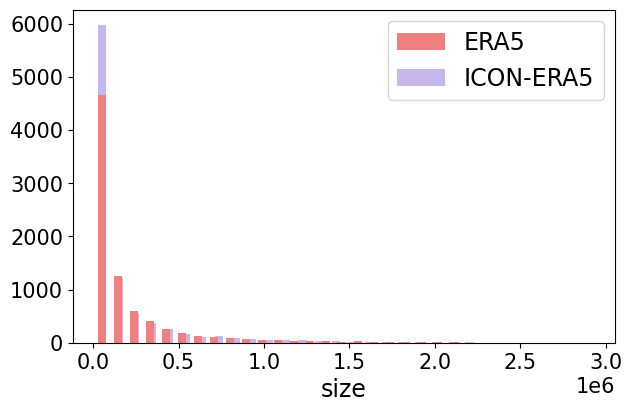

In [57]:
plt.hist(mean_size_ERA5,bins=30,color='lightcoral',zorder=1,rwidth=0.5,label='ERA5')
plt.hist(mean_size_ICONERA5,bins=30,color='mediumpurple',zorder=0,alpha=0.5,rwidth=0.5,label='ICON-ERA5')
plt.xlabel('size')
plt.legend()

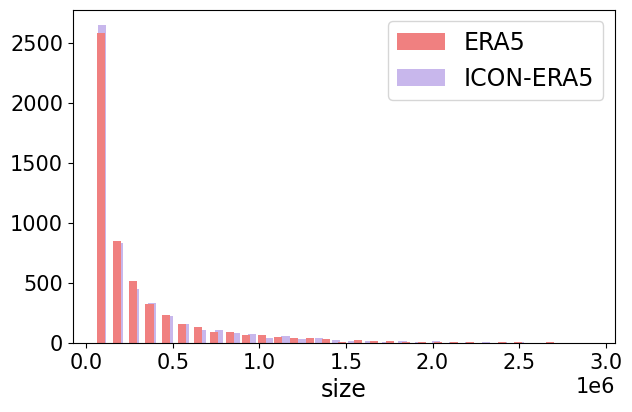

In [118]:
# Convert lists to numpy arrays
mean_size_ICONERA5 = np.array(mean_size_ICONERA5)
mean_size_ERA5 = np.array(mean_size_ERA5)  # make sure ERA5 is also an array

plt.hist(mean_size_ERA5[mean_size_ERA5 > 0.04e6],bins=30,color='lightcoral',zorder=1,rwidth=0.5,label='ERA5')
plt.hist(mean_size_ICONERA5[mean_size_ICONERA5 > 0.04e6],bins=30,color='mediumpurple',zorder=0,alpha=0.5,rwidth=0.5,label='ICON-ERA5')
plt.xlabel('size')
plt.legend()

In [73]:
# ERA5 All events
dates_ICON_ERA5 = []
length_ICON_ERA5 = []
for i in range(len(objs_sel_all_ERA5)):
    dates_ERA5.append(np.datetime64(objs_sel_all_ERA5[i]['times'][0].values))
    length_ERA5.append(len(objs_sel_all_ERA5[i]['times']))


In [49]:
len(objs_sel)

55

### Old

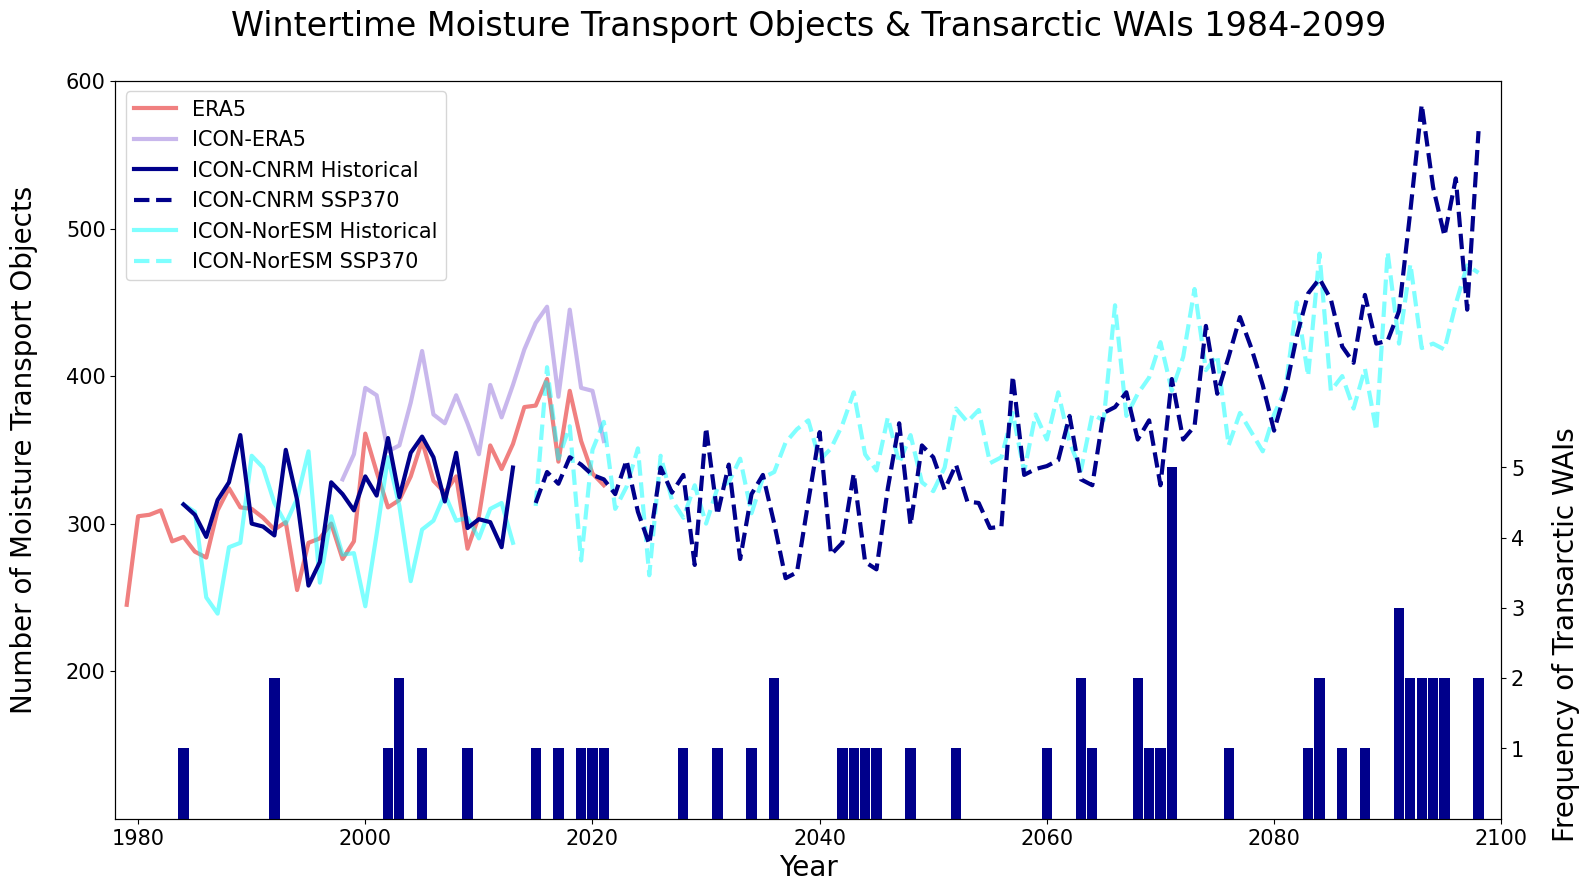

In [14]:
#Plot All Moisture Transport Objects + ERA5 + WAIs ICON-CNRM
plt.rcParams.update({
    'axes.titlesize': 24,        # Title size
    'axes.labelsize': 20,         # Axis label size
    'lines.linewidth': 3,         # Line width
    'lines.markersize': 10,       # Marker size for lines
    'xtick.labelsize': 15,        # X-tick label size
    'ytick.labelsize': 15         # Y-tick label size
})

# Plot
fig, ax = plt.subplots(figsize=(16, 9))
ax2 = ax.twinx()

#Plot ERA5
sns.lineplot(data=df_ERA5, x="Year", y="Event Count", color="lightcoral", label="ERA5",linestyle='-', ax=ax,zorder=1,alpha=1)

#Plot ICON_ERA5
sns.lineplot(data=df_ICONERA5, x="Year", y="Event Count", color="mediumpurple", label="ICON-ERA5",linestyle='-', ax=ax,zorder=1,alpha=0.5)


# Plot regular events as line plots
sns.lineplot(data=df_ICONCNRM_his, x="Year", y="Event Count", color="darkblue", linestyle='-', label="ICON-CNRM Historical", ax=ax,zorder=5)
sns.lineplot(data=df_ICONCNRM, x="Year", y="Event Count", color="darkblue", label="ICON-CNRM SSP370",linestyle='--', ax=ax,zorder=5)

#Plot ICON-NorESM
sns.lineplot(data=df_ICONNorESM_his, x="Year", y="Event Count", color="cyan", linestyle='-', label="ICON-NorESM Historical", ax=ax,zorder=1,alpha=0.5)
sns.lineplot(data=df_ICONNorESM, x="Year", y="Event Count", color="cyan", label="ICON-NorESM SSP370",linestyle='--', ax=ax,zorder=1,alpha=0.5)


for _, row in df_all_TA_ICONCNRM.iterrows():
    # The color of the bars is based on the frequency, but the height is constant (600)
    ax2.bar(row["Year"], height=row["WAIs Count"],color='darkblue', width=0.9, alpha=1.0)

# Main axis settings
ax.set_xlabel("Year")
ax.set_ylabel("Number of Moisture Transport Objects",labelpad=20)
ax.set_ylim([100, 600])
ax.set_yticks([200, 300, 400, 500, 600])
ax.set_xlim([1978,2100])
ax.set_title("Wintertime Moisture Transport Objects & Transarctic WAIs 1984-2099",y=1.05)
ax2.set_ylabel("Frequency of Transarctic WAIs",y=0.25,labelpad=20)
ax2.set_ylim([0, 10.5])
ax2.set_yticks([1,2,3,4,5])

# Legend for regular events only
ax.legend(loc="upper left",fontsize=15)

plt.tight_layout()
plt.show()


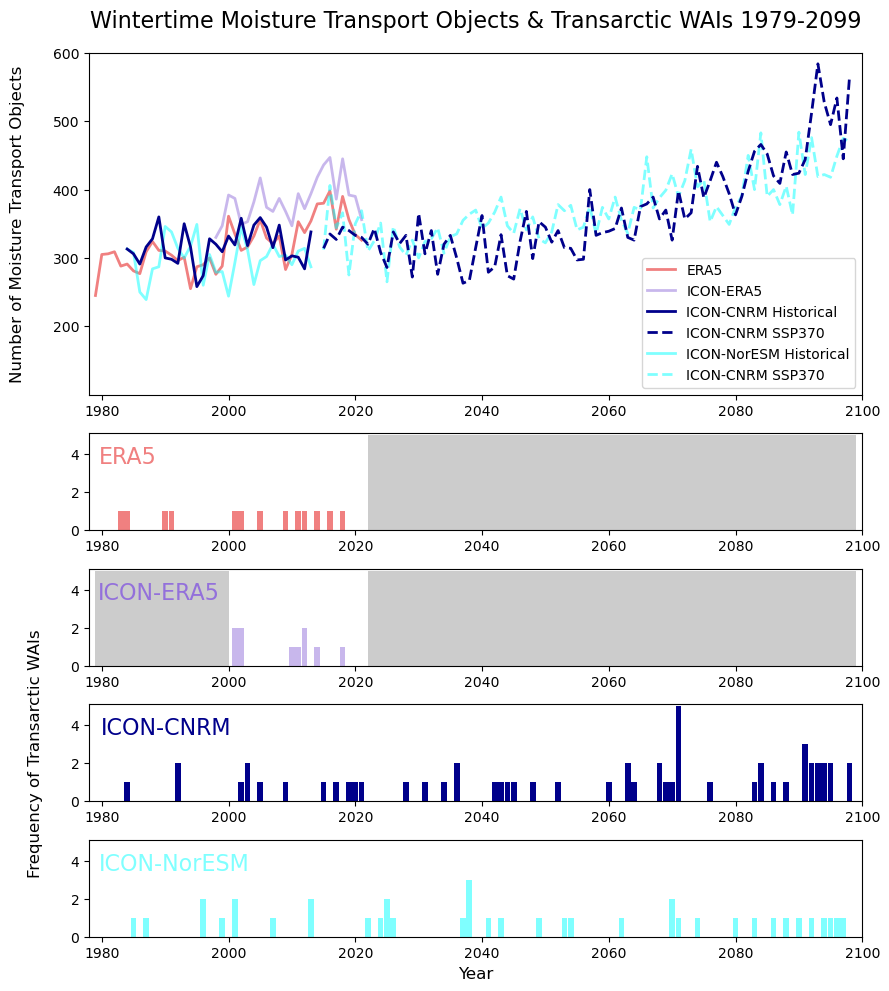

In [81]:
#Plot All Moisture Transport Objects + ERA5 + WAIs ICON-CNRM
plt.rcParams.update({
    'axes.titlesize': 16,        # Title size
    'axes.labelsize': 12,         # Axis label size
    'lines.linewidth': 2,         # Line width
    'lines.markersize': 10,       # Marker size for lines
    'xtick.labelsize': 10,        # X-tick label size
    'ytick.labelsize': 10         # Y-tick label size
})

# Plot
fig, axs = plt.subplots(5, 1, gridspec_kw={'height_ratios': [6, 1.7,1.7,1.7,1.7]},figsize=(9, 10))

##Main Figure
#Plot ERA5
sns.lineplot(data=df_ERA5, x="Year", y="Event Count", color="lightcoral", label="ERA5",linestyle='-', ax=axs[0],zorder=1,alpha=1)

#Plot ICON_ERA5
sns.lineplot(data=df_ICONERA5, x="Year", y="Event Count", color="mediumpurple", label="ICON-ERA5",linestyle='-', ax=axs[0],zorder=1,alpha=0.5)

# Plot regular events as line plots
sns.lineplot(data=df_ICONCNRM_his, x="Year", y="Event Count", color="darkblue", linestyle='-', label="ICON-CNRM Historical", ax=axs[0],zorder=5)
sns.lineplot(data=df_ICONCNRM, x="Year", y="Event Count", color="darkblue", label="ICON-CNRM SSP370",linestyle='--', ax=axs[0],zorder=5)

#Plot ICON-NorESM
sns.lineplot(data=df_ICONNorESM_his, x="Year", y="Event Count", color="cyan", linestyle='-', label="ICON-NorESM Historical", ax=axs[0],zorder=1,alpha=0.5)
sns.lineplot(data=df_ICONNorESM, x="Year", y="Event Count", color="cyan", label="ICON-CNRM SSP370",linestyle='--', ax=axs[0],zorder=1,alpha=0.5)


for aa in axs:
    aa.set_xlim([1978,2100])
    aa.set_ylim([0,5.1])
    aa.set_facecolor('white')  
    
# Main axis settings
axs[0].set_ylabel("Number of Moisture Transport Objects",labelpad=20)
axs[0].set_ylim([100, 600])
axs[0].set_yticks([200, 300, 400, 500, 600])
axs[0].set_title("Wintertime Moisture Transport Objects & Transarctic WAIs 1979-2099",y=1.05)
axs[0].legend(loc="lower right",fontsize=10)

axs[3].set_ylabel("Frequency of Transarctic WAIs",labelpad=20,y=0.5)

axs[1].add_patch(mpatches.Rectangle((2022, 0), 77, 5, linewidth=1, edgecolor='none', facecolor="gray",alpha=0.4))
axs[2].add_patch(mpatches.Rectangle((1979, 0), 21, 5, linewidth=1,edgecolor='none', facecolor="gray",alpha=0.4))
axs[2].add_patch(mpatches.Rectangle((2022, 0), 77, 5, linewidth=1,edgecolor='none', facecolor="gray",alpha=0.4))

# Lower Figure
for _, row in df_TA_ERA5.iterrows():
    # The color of the bars is based on the frequency, but the height is constant (600)
    #grey background for no data
    axs[1].bar(row["Year"], height=row["WAIs Count"],color='lightcoral', width=0.9, alpha=1.0)
    axs[1].set_title("ERA5",y=0.6,x=0.05,color='lightcoral')
    #axs[1].add_patch(mpatches.Rectangle((2022, 0), 77, 5, linewidth=1, edgecolor='none', facecolor="gray",alpha=0.4))

for _, row in df_TA_ICONERA5.iterrows():
    
    # The color of the bars is based on the frequency, but the height is constant (600)
    axs[2].bar(row["Year"], height=row["WAIs Count"],color='mediumpurple', width=0.9, alpha=0.5)
    axs[2].set_title("ICON-ERA5",y=0.6,x=0.09,color='mediumpurple',alpha=1)


for _, row in df_all_TA_ICONCNRM.iterrows():
    # The color of the bars is based on the frequency, but the height is constant (600)
    axs[3].bar(row["Year"], height=row["WAIs Count"],color='darkblue', width=0.9, alpha=1.0)
    axs[3].set_title("ICON-CNRM",y=0.6,x=0.1,color='darkblue')
for _, row in df_all_TA_NorESM.iterrows():
    # The color of the bars is based on the frequency, but the height is constant (600)
    axs[4].bar(row["Year"], height=row["WAIs Count"],color='cyan', width=0.9, alpha=0.5)
    axs[4].set_title("ICON-NorESM",y=0.6,x=0.11,color='cyan',alpha=0.5)

axs[4].set_xlabel("Year")
axs[0].set_xlabel("")
plt.tight_layout()

plt.show()


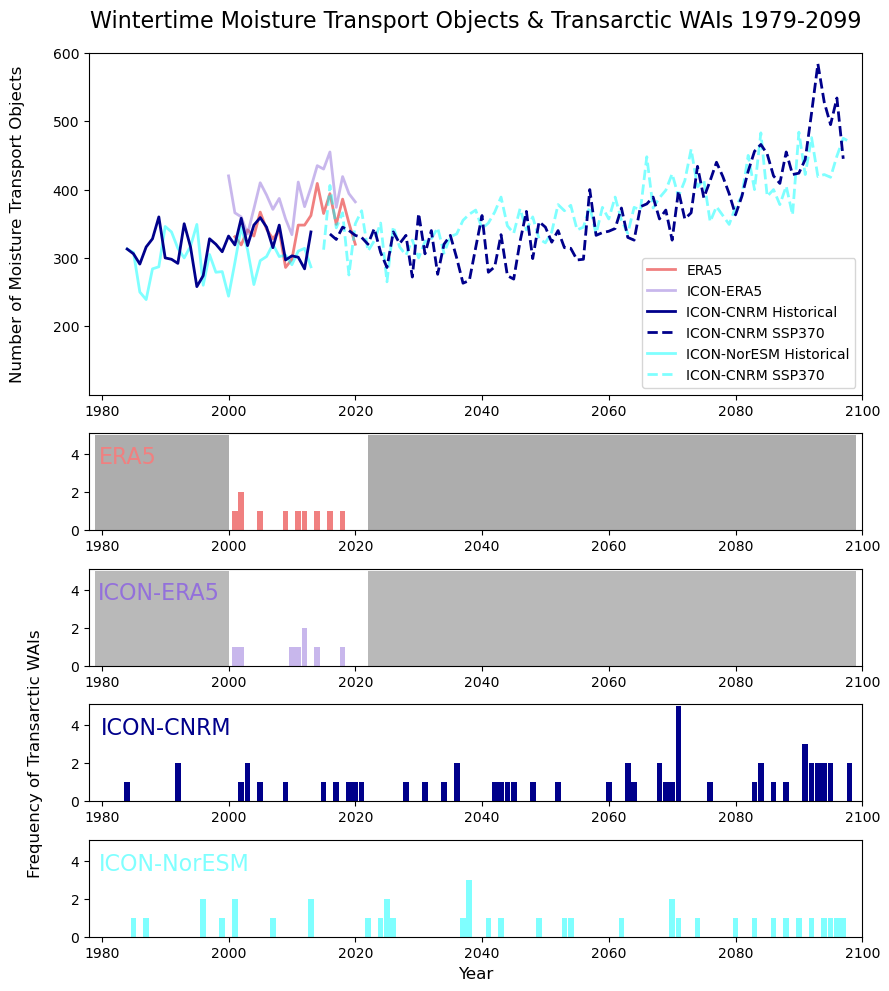

In [99]:
#Only for new climatology
#Plot All Moisture Transport Objects + ERA5 + WAIs ICON-CNRM
plt.rcParams.update({
    'axes.titlesize': 16,        # Title size
    'axes.labelsize': 12,         # Axis label size
    'lines.linewidth': 2,         # Line width
    'lines.markersize': 10,       # Marker size for lines
    'xtick.labelsize': 10,        # X-tick label size
    'ytick.labelsize': 10         # Y-tick label size
})

# Plot
fig, axs = plt.subplots(5, 1, gridspec_kw={'height_ratios': [6, 1.7,1.7,1.7,1.7]},figsize=(9, 10))

##Main Figure
#Plot ERA5
sns.lineplot(data=df_ERA5, x="Year", y="Event Count", color="lightcoral", label="ERA5",linestyle='-', ax=axs[0],zorder=1,alpha=1)

#Plot ICON_ERA5
sns.lineplot(data=df_ICONERA5, x="Year", y="Event Count", color="mediumpurple", label="ICON-ERA5",linestyle='-', ax=axs[0],zorder=1,alpha=0.5)

# Plot regular events as line plots
sns.lineplot(data=df_ICONCNRM_his, x="Year", y="Event Count", color="darkblue", linestyle='-', label="ICON-CNRM Historical", ax=axs[0],zorder=5)
sns.lineplot(data=df_ICONCNRM, x="Year", y="Event Count", color="darkblue", label="ICON-CNRM SSP370",linestyle='--', ax=axs[0],zorder=5)

#Plot ICON-NorESM
sns.lineplot(data=df_ICONNorESM_his, x="Year", y="Event Count", color="cyan", linestyle='-', label="ICON-NorESM Historical", ax=axs[0],zorder=1,alpha=0.5)
sns.lineplot(data=df_ICONNorESM, x="Year", y="Event Count", color="cyan", label="ICON-CNRM SSP370",linestyle='--', ax=axs[0],zorder=1,alpha=0.5)


for aa in axs:
    aa.set_xlim([1978,2100])
    aa.set_ylim([0,5.1])
    
# Main axis settings
axs[0].set_ylabel("Number of Moisture Transport Objects",labelpad=20)
axs[0].set_ylim([100, 600])
axs[0].set_yticks([200, 300, 400, 500, 600])
axs[0].set_title("Wintertime Moisture Transport Objects & Transarctic WAIs 1979-2099",y=1.05)
axs[0].legend(loc="lower right",fontsize=10)

axs[3].set_ylabel("Frequency of Transarctic WAIs",labelpad=20,y=0.5)



#grey background for no data
rect = mpatches.Rectangle((1979, 0), 21, 5, linewidth=1,
                     edgecolor='none', facecolor="gray",alpha=0.1)
rect2 = mpatches.Rectangle((2022, 0), 77, 5, linewidth=1,
                 edgecolor='none', facecolor="gray",alpha=0.1)
#grey background for no data
rect3 = mpatches.Rectangle((1979, 0), 21, 5, linewidth=1,
                     edgecolor='none', facecolor="gray",alpha=0.1)
rect4 = mpatches.Rectangle((2022, 0), 77, 5, linewidth=1,
                 edgecolor='none', facecolor="gray",alpha=0.1)

# Lower Figure
for _, row in df_TA_ERA5.iterrows():
    # The color of the bars is based on the frequency, but the height is constant (600)
    axs[1].bar(row["Year"], height=row["WAIs Count"],color='lightcoral', width=0.9, alpha=1.0)
    axs[1].set_title("ERA5",y=0.6,x=0.05,color='lightcoral',zorder=11)

    # Add the patch to the Axes
    axs[1].add_patch(rect)
    axs[1].add_patch(rect2)
        
        

for _, row in df_TA_ICONERA5.iterrows():
    # The color of the bars is based on the frequency, but the height is constant (600)
    axs[2].bar(row["Year"], height=row["WAIs Count"],color='mediumpurple', width=0.9, alpha=0.5)
    axs[2].set_title("ICON-ERA5",y=0.6,x=0.09,color='mediumpurple',alpha=1,zorder=11)
    axs[2].add_patch(rect3)
    axs[2].add_patch(rect4)

for _, row in df_all_TA_ICONCNRM.iterrows():
    # The color of the bars is based on the frequency, but the height is constant (600)
    axs[3].bar(row["Year"], height=row["WAIs Count"],color='darkblue', width=0.9, alpha=1.0)
    axs[3].set_title("ICON-CNRM",y=0.6,x=0.1,color='darkblue')
for _, row in df_all_TA_NorESM.iterrows():
    # The color of the bars is based on the frequency, but the height is constant (600)
    axs[4].bar(row["Year"], height=row["WAIs Count"],color='cyan', width=0.9, alpha=0.5)
    axs[4].set_title("ICON-NorESM",y=0.6,x=0.11,color='cyan',alpha=0.5)

axs[4].set_xlabel("Year")
axs[0].set_xlabel("")
plt.tight_layout()
plt.show()


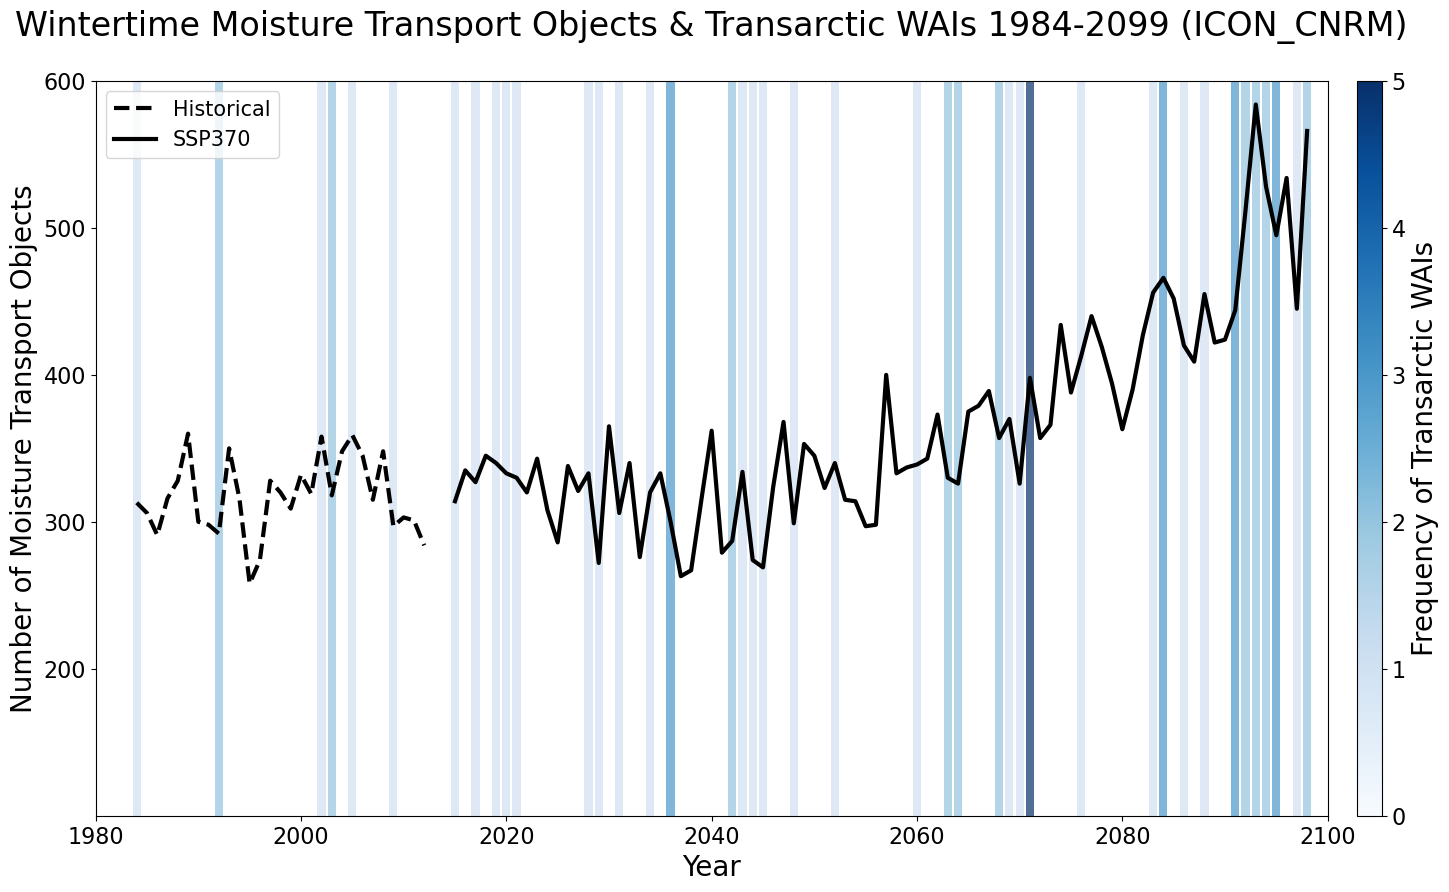

In [127]:

plt.rcParams.update({
    'axes.titlesize': 24,        # Title size
    'axes.labelsize': 20,         # Axis label size
    'lines.linewidth': 3,         # Line width
    'lines.markersize': 10,       # Marker size for lines
    'xtick.labelsize': 16,        # X-tick label size
    'ytick.labelsize': 16         # Y-tick label size
})

# Prepare primary data
df = pd.DataFrame({"Date": pd.to_datetime(dates_all)})
df_his = pd.DataFrame({"Date": pd.to_datetime(dates_his_all)})
df["Year"] = df["Date"].dt.year
df_his["Year"] = df_his["Date"].dt.year

df_yearly = df["Year"].value_counts().sort_index().reset_index()
df_yearly.columns = ["Year", "Event Count"]
df_yearly = df_yearly.iloc[:-1]

df_his_yearly = df_his["Year"].value_counts().sort_index().reset_index()
df_his_yearly.columns = ["Year", "Event Count"]
df_his_yearly = df_his_yearly.iloc[:-1]

# Prepare special events
df_special = pd.DataFrame({"Date": pd.to_datetime(dates)})
df_his_special = pd.DataFrame({"Date": pd.to_datetime(dates_his)})
df_special["Year"] = df_special["Date"].dt.year
df_his_special["Year"] = df_his_special["Date"].dt.year

# Combine special events
df_combined_special = pd.concat([df_special, df_his_special])
df_yearly_special = df_combined_special["Year"].value_counts().sort_index().reset_index()
df_yearly_special.columns = ["Year", "Special Event Count"]

# Normalize for colormap
norm = Normalize(vmin=0, vmax=5)
cmap = cm.Blues
sm = ScalarMappable(norm=norm, cmap=cmap)

# Plot
fig, ax = plt.subplots(figsize=(16, 9))

# Plot regular events as line plots
sns.lineplot(data=df_his_yearly, x="Year", y="Event Count", color="black", linestyle='--', label="Historical", ax=ax)
sns.lineplot(data=df_yearly, x="Year", y="Event Count", color="black", label="SSP370", ax=ax)

# Plot special events as vertical bars with a constant height of 600
bar_height = 600  # Set the constant height of the bars

for _, row in df_yearly_special.iterrows():
    # The color of the bars is based on the frequency, but the height is constant (600)
    ax.bar(row["Year"], height=bar_height, color=cmap(norm(row["Special Event Count"])), width=0.8, alpha=0.7)

# Main axis settings
ax.set_xlabel("Year")
ax.set_ylabel("Number of Moisture Transport Objects")
ax.set_ylim([100, 600])
ax.set_yticks([200, 300, 400, 500, 600])
ax.set_xlim([1980,2100])
ax.set_title("Wintertime Moisture Transport Objects & Transarctic WAIs 1984-2099 (ICON_CNRM)",y=1.05)


# Legend for regular events only
ax.legend(loc="upper left",fontsize=15)

# Add colorbar
cbar = fig.colorbar(sm, ax=ax, orientation="vertical", pad=0.02, aspect=30)
cbar.set_label("Frequency of Transarctic WAIs")

plt.tight_layout()
plt.show()


In [43]:
from matplotlib.colors import to_hex

# Extract the darkest color from the 'Blues' colormap (near 1.0)
darkest_blue = cm.get_cmap('Blues')(100.0)

darkest_blue_hex = to_hex(darkest_blue)
print(darkest_blue_hex)


#08306b


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib import cm
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
plt.rcParams.update({
    'axes.titlesize': 24,        # Title size
    'axes.labelsize': 20,         # Axis label size
    'lines.linewidth': 3,         # Line width
    'lines.markersize': 10,       # Marker size for lines
    'xtick.labelsize': 16,        # X-tick label size
    'ytick.labelsize': 16         # Y-tick label size
})

# Prepare primary data
df = pd.DataFrame({"Date": pd.to_datetime(dates_all)})
df_his = pd.DataFrame({"Date": pd.to_datetime(dates_his_all)})
df["Year"] = df["Date"].dt.year
df_his["Year"] = df_his["Date"].dt.year

df_yearly = df["Year"].value_counts().sort_index().reset_index()
df_yearly.columns = ["Year", "Event Count"]
df_yearly = df_yearly.iloc[:-1]

df_his_yearly = df_his["Year"].value_counts().sort_index().reset_index()
df_his_yearly.columns = ["Year", "Event Count"]
df_his_yearly = df_his_yearly.iloc[:-1]

# Prepare special events
df_special = pd.DataFrame({"Date": pd.to_datetime(dates)})
df_his_special = pd.DataFrame({"Date": pd.to_datetime(dates_his)})
df_special["Year"] = df_special["Date"].dt.year
df_his_special["Year"] = df_his_special["Date"].dt.year

# Combine special events
df_combined_special = pd.concat([df_special, df_his_special])
df_yearly_special = df_combined_special["Year"].value_counts().sort_index().reset_index()
df_yearly_special.columns = ["Year", "Special Event Count"]

# Normalize for colormap
norm = Normalize(vmin=0, vmax=5)
cmap = cm.Blues
sm = ScalarMappable(norm=norm, cmap=cmap)

# Plot
fig, ax = plt.subplots(figsize=(16, 9))

# Plot regular events as line plots
sns.lineplot(data=df_his_yearly, x="Year", y="Event Count", color="black", linestyle='--', label="Historical", ax=ax)
sns.lineplot(data=df_yearly, x="Year", y="Event Count", color="black", label="SSP370", ax=ax)

# Plot special events as vertical bars with a constant height of 600
bar_height = 600  # Set the constant height of the bars

for _, row in df_yearly_special.iterrows():
    # The color of the bars is based on the frequency, but the height is constant (600)
    ax.bar(row["Year"], height=bar_height, color=cmap(norm(row["Special Event Count"])), width=0.8, alpha=0.7)

# Main axis settings
ax.set_xlabel("Year")
ax.set_ylabel("Number of Moisture Transport Objects")
ax.set_ylim([100, 600])
ax.set_yticks([200, 300, 400, 500, 600])
ax.set_xlim([1980,2100])
ax.set_title("Wintertime Moisture Transport Objects & Transarctic WAIs 1984-2099 (ICON_CNRM)",y=1.05)


# Legend for regular events only
ax.legend(loc="upper left",fontsize=15)

# Add colorbar
cbar = fig.colorbar(sm, ax=ax, orientation="vertical", pad=0.02, aspect=30)
cbar.set_label("Frequency of Transarctic WAIs")

plt.tight_layout()
plt.show()


#### Objects 2015-2039

In [45]:
with open('/work/aa0049/a271122/MOAAP/IVT_Tracking/CNRM_ssp_remapped_3x/Object_container_2015-2039_withClusters_filtered.pkl', 'rb') as f:
    objs_final = pickle.load(f)

In [46]:
def define_df_objs(objs):
    df_objs = pd.DataFrame({
        'id': [ds.id_.item() for ds in objs],
        'color': [plt.get_cmap("tab20b")(i / len(objs))[:3] for i in range(len(objs))]
    })
    return df_objs


### Stats

#### ICON_CNRM

In [50]:
# Load the CSV
df = pd.read_csv("ICON_CNRM_all_all.csv")

# Split the combined column
df[['Year', 'Event_Count']] = df['Year;Event Count'].str.split(';', expand=True)

# Drop rows with empty values
df = df.dropna()
df = df[(df['Year'].str.strip() != '') & (df['Event_Count'].str.strip() != '')]

# Convert types
df['Year'] = df['Year'].astype(int)
df['Event_Count'] = df['Event_Count'].astype(int)


In [51]:
df['Event_Count'].index.values

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114])

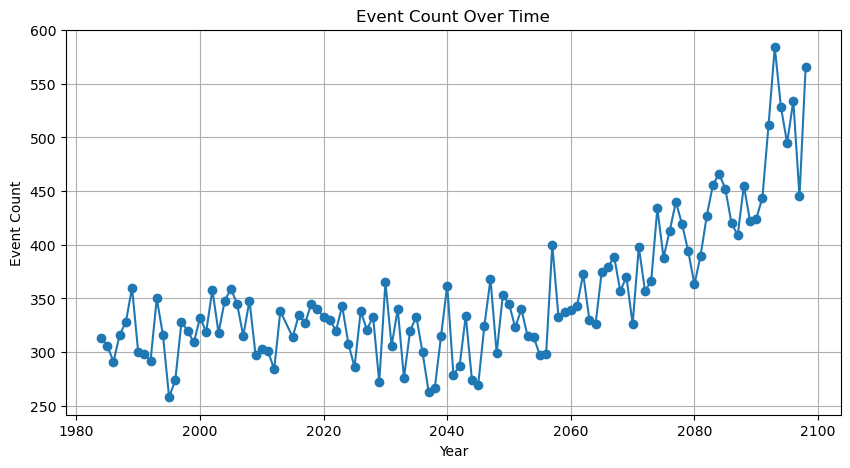

In [53]:
plt.figure(figsize=(10, 5))
plt.plot(df['Year'], df['Event_Count'], marker='o')
plt.title('Event Count Over Time')
plt.xlabel('Year')
plt.ylabel('Event Count')
plt.grid(True)
plt.show()


In [54]:
slope, intercept, r_value, p_value, std_err = linregress(df['Year'], df['Event_Count'])
print(f"Linear R²: {r_value**2}")

Linear R²: 0.5018371032690863


In [55]:
slope, intercept, r_value, p_value, std_err = linregress(df['Event_Count'].index.values, df['Event_Count'].values)
print(f"Linear R²: {r_value**2}")

Linear R²: 0.5018371032690858


In [56]:
type(r_value)

numpy.float64

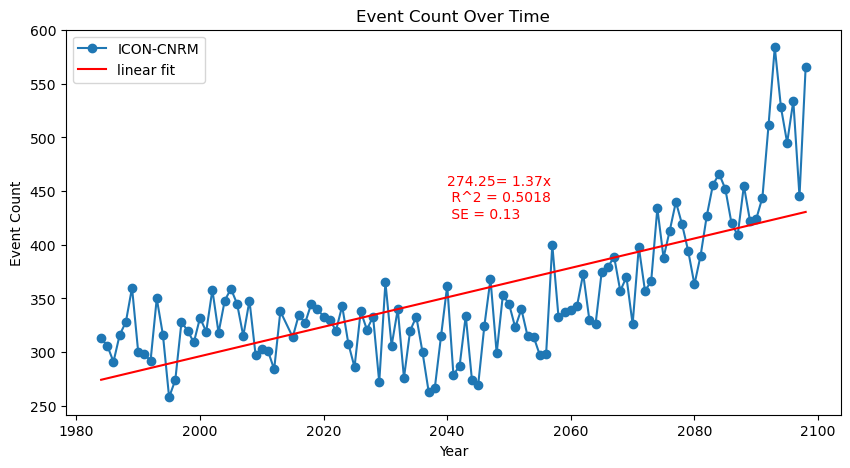

In [59]:
plt.figure(figsize=(10, 5))
plt.plot(df['Year'], df['Event_Count'], marker='o',label='ICON-CNRM')
plt.plot(df['Year'], intercept + slope*df['Event_Count'].index.values,'r',label='linear fit')
plt.text(2040,425,f"{intercept:.2f}= {slope:.2f}x  \n R^2 = {r_value**2:.4f} \n SE = {std_err:.2f}",color='r')
plt.title('Event Count Over Time')
plt.xlabel('Year')
plt.ylabel('Event Count')
#plt.grid(True)
plt.legend()
plt.show()


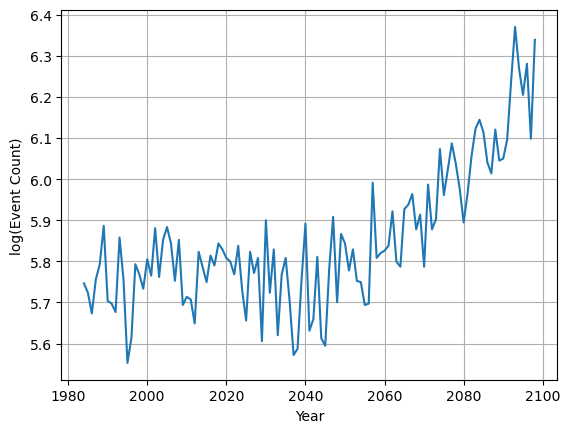

In [60]:
plt.plot(df['Year'], np.log(df['Event_Count']))
plt.xlabel('Year')
plt.ylabel('log(Event Count)')
plt.grid(True)
plt.show()


In [66]:

# Normalize year
t = df['Event_Count'].index.values
log_y = np.log(df['Event_Count'])

# Linear regression on log(y)
slope, intercept, r_value, p_value, std_err = linregress(t, log_y)

# Reconstruct exponential model: Event_Count = a * exp(b * t)
a = np.exp(intercept)
b = slope
r_squared = r_value ** 2

print(f"Exponential model: Event_Count = {a:.2f} * exp({b:.4f} * t)")
print(f"R²: {r_squared:.4f}")


Exponential model: Event_Count = 283.05 * exp(0.0036 * t)
R²: 0.5006


In [67]:
b

0.0035853627092271158

In [68]:
growth_rate_percent = (np.exp(b) - 1) * 100
print(f"Annual growth rate: {growth_rate_percent:.2f}%")



Annual growth rate: 0.36%


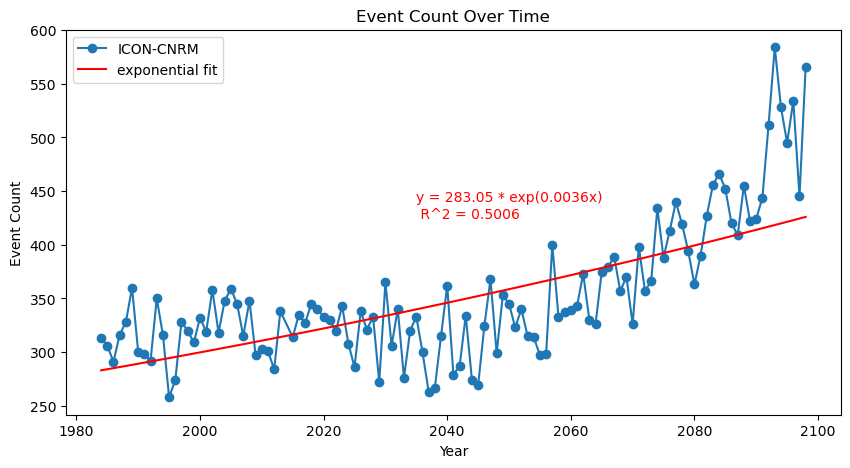

In [69]:
plt.figure(figsize=(10, 5))
plt.plot(df['Year'], df['Event_Count'], marker='o',label='ICON-CNRM')
plt.plot(df['Year'], a*np.exp(b*df['Event_Count'].index.values),'r',label='exponential fit')
plt.text(2035,425,f"y = {a:.2f} * exp({b:.4f}x) \n R^2 = {r_squared:.4f}",color='r')
plt.title('Event Count Over Time')
plt.xlabel('Year')
plt.ylabel('Event Count')
#plt.grid(True)
plt.legend()
plt.show()

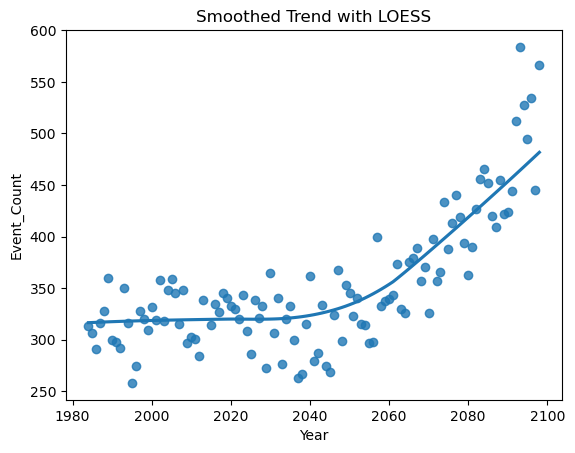

In [70]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.regplot(data=df, x='Year', y='Event_Count', lowess=True)
plt.title('Smoothed Trend with LOESS')
plt.show()


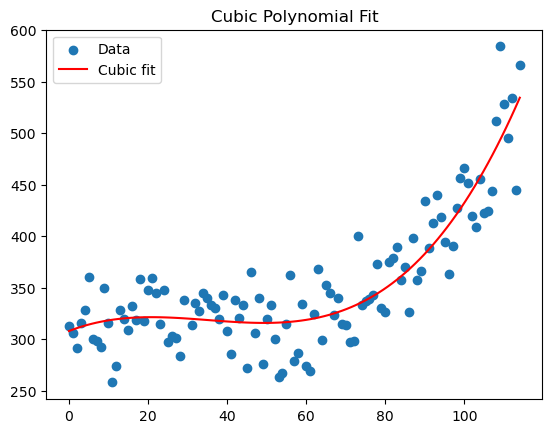

In [82]:
from numpy.polynomial.polynomial import Polynomial

# Normalize x
x = df['Event_Count'].index.values
y = df['Event_Count']
p = Polynomial.fit(x, y, deg=3)

# Plot
x_plot = np.linspace(x.min(), x.max(), 100)
y_plot = p(x_plot)

plt.scatter(x, y, label='Data')
plt.plot(x_plot + 0, y_plot, color='red', label='Cubic fit')
plt.title("Cubic Polynomial Fit")
plt.legend()
plt.show()


In [81]:

results_df = pd.DataFrame(results)
print(results_df)


Empty DataFrame
Columns: []
Index: []


In [87]:
bins = [1984, 2015, 2040,2070, df['Year'].max() + 1]
labels = ['1984-2014', '2015-2039','2040-2069','2070-2099']
df['Period'] = pd.cut(df['Year'], bins=bins, labels=labels, right=False)

In [88]:
from scipy.stats import linregress
import numpy as np

results = []

for period, group in df.groupby('Period'):
    x = group['Year'] - group['Year'].min()
    y = group['Event_Count']
    if (y <= 0).any():
        continue  # avoid log(0) issues
    
    log_y = np.log(y)
    slope, intercept, r_value, p_value, std_err = linregress(x, log_y)
    growth_rate = (np.exp(slope) - 1) * 100
    
    results.append({
        'Period': period,
        'Growth rate (%)': growth_rate,
        'R²': r_value ** 2,
        'Equation': f"y = {np.exp(intercept):.2f} * e^({slope:.4f} * t)"
    })


In [89]:
import pandas as pd
results_df = pd.DataFrame(results)
print(results_df)


      Period  Growth rate (%)        R²                      Equation
0  1984-2014         0.136320  0.021148   y = 310.24 * e^(0.0014 * t)
1  2015-2039        -0.550031  0.216099  y = 337.69 * e^(-0.0055 * t)
2  2040-2069         0.680561  0.319555   y = 301.47 * e^(0.0068 * t)
3  2070-2099         1.297495  0.637750   y = 363.03 * e^(0.0129 * t)


#### ICON_NorESM

In [32]:
# Load the CSV
df_NE = pd.read_csv("ICON_NorESM_all_all.csv")

# Split the combined column
df_NE[['Year', 'Event_Count']] = df_NE['Year;Event Count'].str.split(';', expand=True)

# Drop rows with empty values
df_NE = df_NE.dropna()
df_NE = df_NE[(df_NE['Year'].str.strip() != '') & (df_NE['Event_Count'].str.strip() != '')]

# Convert types
df_NE['Year'] = df_NE['Year'].astype(int)
df_NE['Event_Count'] = df_NE['Event_Count'].astype(int)


In [33]:
df_NE

,Year;Event Count,Year,Event_Count
0,1984;313,1984,313
1,1985;308,1985,308
2,1986;250,1986,250
3,1987;239,1987,239
4,1988;284,1988,284
...,...,...,...
110,2094;422,2094,422
111,2095;418,2095,418
112,2096;449,2096,449
113,2097;475,2097,475


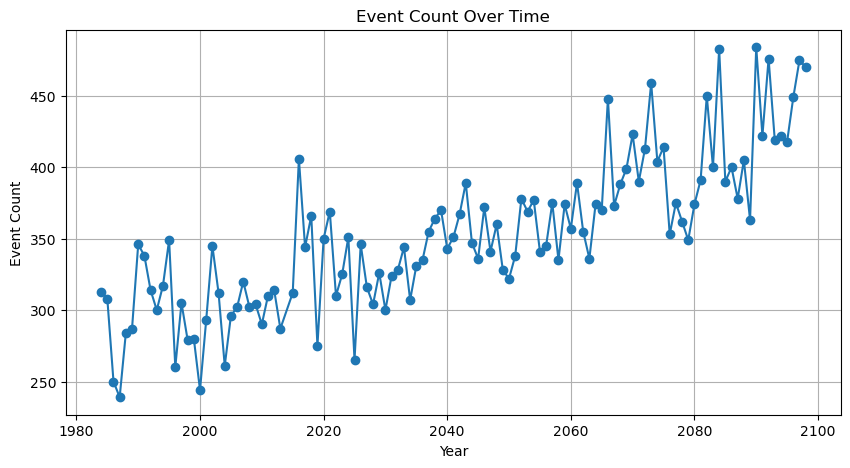

In [34]:
plt.figure(figsize=(10, 5))
plt.plot(df_NE['Year'], df_NE['Event_Count'], marker='o')
plt.title('Event Count Over Time')
plt.xlabel('Year')
plt.ylabel('Event Count')
plt.grid(True)
plt.show()


In [37]:
slope, intercept, r_value, p_value, std_err = linregress(df_NE['Year'], df_NE['Event_Count'])
print(f"Linear R²: {r_value**2}")

Linear R²: 0.6658026653849247


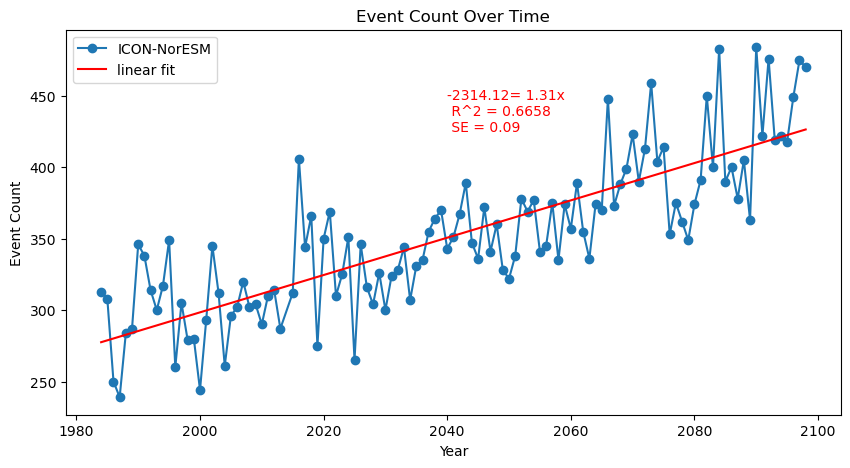

In [40]:
slope, intercept, r_value, p_value, std_err = linregress(df_NE['Year'], df_NE['Event_Count'])
print(f"Linear R²: {r_value**2}")

plt.figure(figsize=(10, 5))
plt.plot(df_NE['Year'], df_NE['Event_Count'], marker='o',label='ICON-NorESM')
plt.plot(df_NE['Year'], intercept + slope*df_NE['Year'],'r',label='linear fit')
plt.text(2040,425,f"{intercept:.2f}= {slope:.2f}x  \n R^2 = {r_value**2:.4f} \n SE = {std_err:.2f}",color='r')
plt.title('Event Count Over Time')
plt.xlabel('Year')
plt.ylabel('Event Count')
#plt.grid(True)
plt.legend()
plt.show()


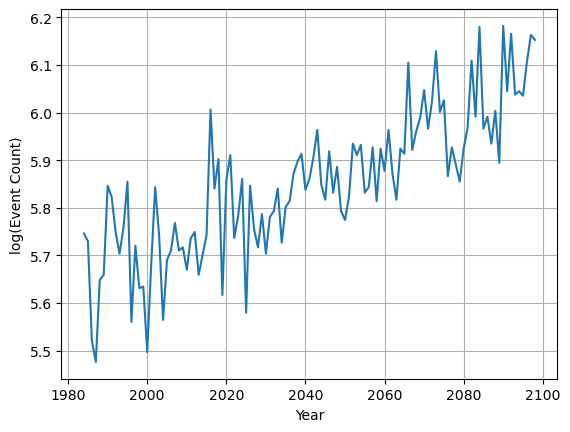

In [41]:
plt.plot(df_NE['Year'], np.log(df_NE['Event_Count']))
plt.xlabel('Year')
plt.ylabel('log(Event Count)')
plt.grid(True)
plt.show()


In [42]:

# Normalize year
t = df_NE['Event_Count'].index.values
log_y = np.log(df_NE['Event_Count'])

# Linear regression on log(y)
slope, intercept, r_value, p_value, std_err = linregress(t, log_y)

# Reconstruct exponential model: Event_Count = a * exp(b * t)
a = np.exp(intercept)
b = slope
r_squared = r_value ** 2

print(f"Exponential model: Event_Count = {a:.2f} * exp({b:.4f} * t)")
print(f"R²: {r_squared:.4f}")


Exponential model: Event_Count = 281.74 * exp(0.0037 * t)
R²: 0.6682


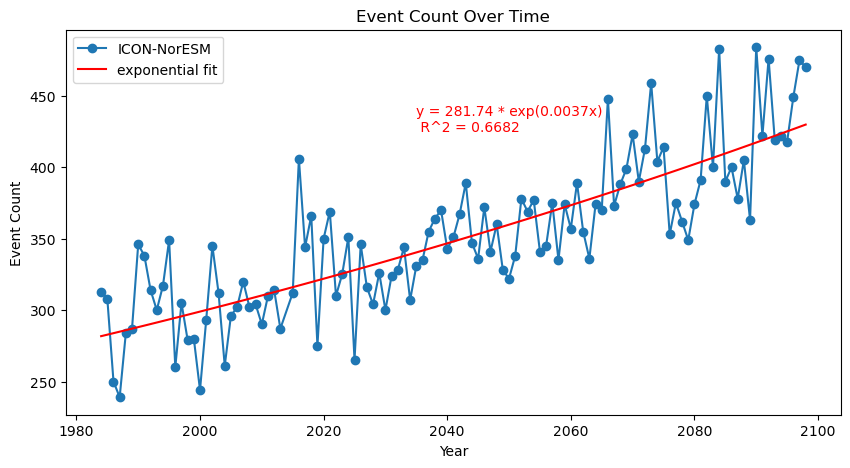

In [44]:
plt.figure(figsize=(10, 5))
plt.plot(df_NE['Year'], df_NE['Event_Count'], marker='o',label='ICON-NorESM')
plt.plot(df_NE['Year'], a*np.exp(b*df_NE['Event_Count'].index.values),'r',label='exponential fit')
plt.text(2035,425,f"y = {a:.2f} * exp({b:.4f}x) \n R^2 = {r_squared:.4f}",color='r')
plt.title('Event Count Over Time')
plt.xlabel('Year')
plt.ylabel('Event Count')
#plt.grid(True)
plt.legend()
plt.show()

In [90]:
bins = [1984, 2015, 2040,2070, df_NE['Year'].max() + 1]
labels = ['1984-2014', '2015-2039','2040-2069','2070-2099']
df_NE['Period'] = pd.cut(df_NE['Year'], bins=bins, labels=labels, right=False)

In [91]:
bins = [1984, 2015, 2040,2070, df_NE['Year'].max() + 1]
labels = ['1984-2014', '2015-2039','2040-2069','2070-2099']
df_NE['Period'] = pd.cut(df_NE['Year'], bins=bins, labels=labels, right=False)

results = []

for period, group in df_NE.groupby('Period'):
    x = group['Year'] - group['Year'].min()
    y = group['Event_Count']
    if (y <= 0).any():
        continue  # avoid log(0) issues
    
    log_y = np.log(y)
    slope, intercept, r_value, p_value, std_err = linregress(x, log_y)
    growth_rate = (np.exp(slope) - 1) * 100
    
    results.append({
        'Period': period,
        'Growth rate (%)': growth_rate,
        'R²': r_value ** 2,
        'Equation': f"y = {np.exp(intercept):.2f} * e^({slope:.4f} * t)"
    })


results_df = pd.DataFrame(results)
print(results_df)



In [92]:

results_df = pd.DataFrame(results)
print(results_df)


      Period  Growth rate (%)        R²                     Equation
0  1984-2014         0.102849  0.008568  y = 292.55 * e^(0.0010 * t)
1  2015-2039         0.045478  0.001227  y = 329.68 * e^(0.0005 * t)
2  2040-2069         0.353990  0.199628  y = 343.64 * e^(0.0035 * t)
3  2070-2099         0.477465  0.177228  y = 385.72 * e^(0.0048 * t)


#### ERA5

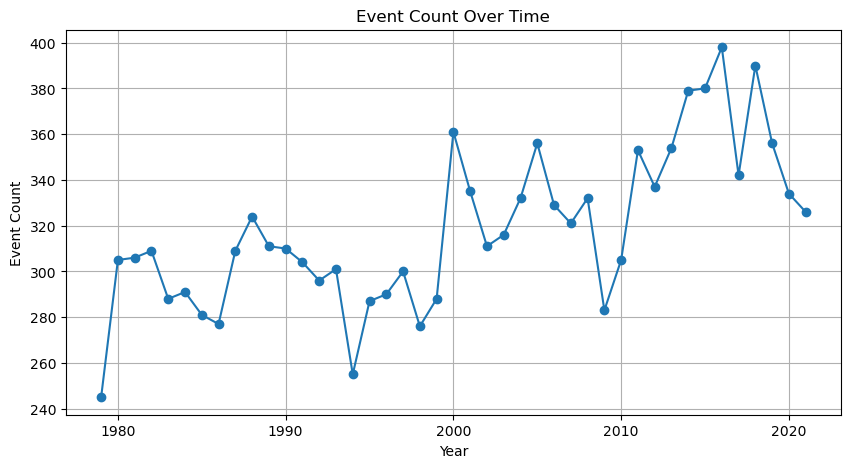

In [27]:
plt.figure(figsize=(10, 5))
plt.plot(df_ERA5['Year'], df_ERA5['Event Count'], marker='o')
plt.title('Event Count Over Time')
plt.xlabel('Year')
plt.ylabel('Event Count')
plt.grid(True)
plt.show()


In [22]:
slope, intercept, r_value, p_value, std_err = linregress(df_ERA5['Year'], df_ERA5['Event Count'])
print(f"Linear R²: {r_value**2}")

Linear R²: 0.48848923250593185


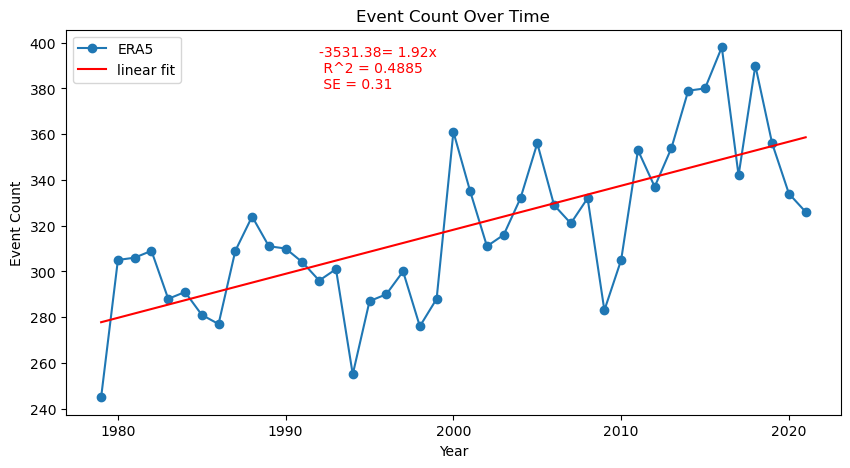

In [29]:
plt.figure(figsize=(10, 5))
plt.plot(df_ERA5['Year'], df_ERA5['Event Count'], marker='o',label='ERA5')
plt.plot(df_ERA5['Year'], intercept + slope*df_ERA5['Year'],'r',label='linear fit')
plt.text(1992,380,f"{intercept:.2f}= {slope:.2f}x  \n R^2 = {r_value**2:.4f} \n SE = {std_err:.2f}",color='r')
plt.title('Event Count Over Time')
plt.xlabel('Year')
plt.ylabel('Event Count')
#plt.grid(True)
plt.legend()
plt.show()


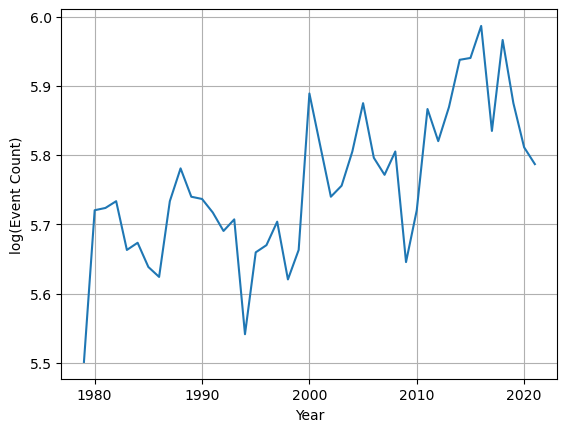

In [24]:
plt.plot(df_ERA5['Year'], np.log(df_ERA5['Event Count']))
plt.xlabel('Year')
plt.ylabel('log(Event Count)')
plt.grid(True)
plt.show()


In [38]:

# Normalize year
t = df_ERA5['Event Count'].index.values
log_y = np.log(df_ERA5['Event Count'])

# Linear regression on log(y)
slope, intercept, r_value, p_value, std_err = linregress(t, log_y)

# Reconstruct exponential model: Event_Count = a * exp(b * t)
a = np.exp(intercept)
b = slope
r_squared = r_value ** 2

print(f"Exponential model: Event_Count = {a:.2f} * exp({b:.4f} * t)")
print(f"R²: {r_squared:.4f}")


Exponential model: Event_Count = 279.04 * exp(0.0060 * t)
R²: 0.4834


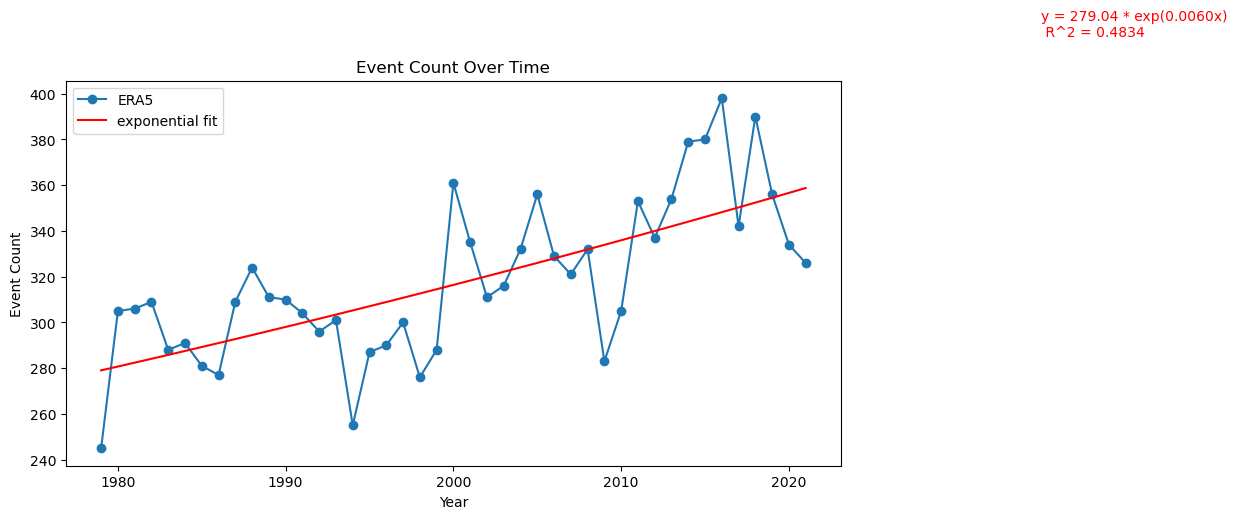

0.6000499220884636


In [39]:
plt.figure(figsize=(10, 5))
plt.plot(df_ERA5['Year'], df_ERA5['Event Count'], marker='o',label='ERA5')
plt.plot(df_ERA5['Year'], a*np.exp(b*df_ERA5['Event Count'].index.values),'r',label='exponential fit')
plt.text(2035,425,f"y = {a:.2f} * exp({b:.4f}x) \n R^2 = {r_squared:.4f}",color='r')
plt.title('Event Count Over Time')
plt.xlabel('Year')
plt.ylabel('Event Count')
#plt.grid(True)
plt.legend()
plt.show()
growth_rate = (np.exp(slope) - 1) * 100
print(growth_rate)

In [34]:
bins = [1979, 2001, df_ERA5['Year'].max() + 1]
labels = ['1979-2000', '2001-2022']
df_ERA5['Period'] = pd.cut(df_ERA5['Year'], bins=bins, labels=labels, right=False)

In [36]:

results = []

for period, group in df_ERA5.groupby('Period'):
    x = group['Year'] - group['Year'].min()
    y = group['Event Count']
    if (y <= 0).any():
        continue  # avoid log(0) issues
    
    log_y = np.log(y)
    slope, intercept, r_value, p_value, std_err = linregress(x, log_y)
    growth_rate = (np.exp(slope) - 1) * 100
    
    results.append({
        'Period': period,
        'Growth rate (%)': growth_rate,
        'R²': r_value ** 2,
        'Equation': f"y = {np.exp(intercept):.2f} * e^({slope:.4f} * t)"
    })


In [37]:

results_df = pd.DataFrame(results)
print(results_df)


      Period  Growth rate (%)        R²                     Equation
0  1979-2000         0.231158  0.035757  y = 288.13 * e^(0.0023 * t)
1  2001-2022         0.622872  0.209412  y = 319.75 * e^(0.0062 * t)
